In [2]:
# Model DLinear
from re import X
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x


class series_decomp(nn.Module):
    """
    Series decomposition block
    """
    def __init__(self, kernel_size):
        super(series_decomp, self).__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        res = x - moving_mean
        return res, moving_mean

class Model(nn.Module):
    """
    DLinear
    """
    def __init__(self, configs):
        super(Model, self).__init__()
        self.seq_len = configs.seq_len
        self.pred_len = configs.pred_len

        # Decompsition Kernel Size
        kernel_size = 25
        self.decompsition = series_decomp(kernel_size)
        self.individual = configs.individual
        self.channels = configs.enc_in

        if self.individual:
            self.Linear_Seasonal = nn.ModuleList()
            self.Linear_Trend = nn.ModuleList()
            self.Linear_Decoder = nn.ModuleList()
            for i in range(self.channels):
                self.Linear_Seasonal.append(nn.Linear(self.seq_len,self.pred_len))
                self.Linear_Seasonal[i].weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
                self.Linear_Trend.append(nn.Linear(self.seq_len,self.pred_len))
                self.Linear_Trend[i].weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
                self.Linear_Decoder.append(nn.Linear(self.seq_len,self.pred_len))
        else:
            self.Linear_Seasonal = nn.Linear(self.seq_len,self.pred_len)
            self.Linear_Trend = nn.Linear(self.seq_len,self.pred_len)
            self.Linear_Decoder = nn.Linear(self.seq_len,self.pred_len)
            self.Linear_Seasonal.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
            self.Linear_Trend.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))

    def forward(self, x):
        # x: [Batch, Input length, Channel]
        seasonal_init, trend_init = self.decompsition(x)
        seasonal_init, trend_init = seasonal_init.permute(0,2,1), trend_init.permute(0,2,1)
        if self.individual:
            seasonal_output = torch.zeros([seasonal_init.size(0),seasonal_init.size(1),self.pred_len],dtype=seasonal_init.dtype).to(seasonal_init.device)
            trend_output = torch.zeros([trend_init.size(0),trend_init.size(1),self.pred_len],dtype=trend_init.dtype).to(trend_init.device)
            for i in range(self.channels):
                seasonal_output[:,i,:] = self.Linear_Seasonal[i](seasonal_init[:,i,:])
                trend_output[:,i,:] = self.Linear_Trend[i](trend_init[:,i,:])
        else:
            seasonal_output = self.Linear_Seasonal(seasonal_init)
            trend_output = self.Linear_Trend(trend_init)

        x = seasonal_output + trend_output
        return x.permute(0,2,1) # to [Batch, Output length, Channel]

In [3]:
#TimeSeriesDataset class
from torch.utils.data import DataLoader, Dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_len, pred_len):
        self.data = data
        self.seq_len = seq_len
        self.pred_len = pred_len

    def __len__(self):
        return len(self.data) - self.seq_len - self.pred_len + 1

    def __getitem__(self, index):
        x = self.data[index : index + self.seq_len]
        y = self.data[index + self.seq_len : index + self.seq_len + self.pred_len]
       
        return x, y

In [4]:
#fit function
def fit(model, train_data, test_data, seq_len, pred_len, batch_size, num_epochs, learning_rate):
    # Create DataLoaders
    train_dataset = TimeSeriesDataset(train_data, seq_len, pred_len)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataset = TimeSeriesDataset(test_data, seq_len, pred_len)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5, verbose=True)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        loop = tqdm(train_loader, leave=True)

        for i, (batch_x, batch_y) in enumerate(train_loader):
            optimizer.zero_grad()

            batch_x = batch_x.float()
            batch_y = batch_y.float()
            output = model(batch_x)

            loss = criterion(output, batch_y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            loop.set_description(f'Epoch [{epoch}/{num_epochs}]')
            loop.set_postfix(loss=loss.item())

        model.eval()
        test_loss = 0
        with torch.no_grad():
            for i, (batch_x, batch_y) in enumerate(test_loader):
                batch_x = batch_x.float()
                batch_y = batch_y.float()
                output = model(batch_x)
                loss = criterion(output, batch_y)
                test_loss += loss.item()

        scheduler.step(test_loss)  # Update learning rate based on test loss

        train_loss /= len(train_loader)
        test_loss /= len(test_loader)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

    return model

In [5]:
def predict_test(model, test_data, seq_len, pred_len, batch_size):
    test_dataset = TimeSeriesDataset(test_data, seq_len, pred_len)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    # Initialize an empty list to store the predictions
    test_pred = []

    # Iterate over the test data
    for i, (batch_x, batch_y) in enumerate(test_loader):
        batch_x = batch_x.float()
        batch_y = batch_y.float()

        # Make predictions
        with torch.no_grad():
            output = model(batch_x)

        # Append the predictions to the list
        test_pred.append(output)

    # Concatenate the predictions into a single tensor
    test_pred_tensor = torch.cat(test_pred, dim=0)

    # Select the last prediction from each sequence
    test_pred_1 = test_pred_tensor[:, -1, :]

    # Detach and convert to numpy array
    test_pred_1 = test_pred_1.detach().cpu().numpy()

    # Inverse transform the predictions

    return test_pred_1

In [6]:
def predict_30(model, test_data, seq_len, prediction_days=30):
    # Lấy 30 phần tử cuối cùng từ tập test
    last_30_days = test_data[-seq_len:]
    # Chuyển đổi thành tensor và thêm một chiều
    input_x = torch.tensor(last_30_days).float().unsqueeze(0)
    # Khởi tạo một danh sách để lưu trữ các dự đoán
    predictions = []

    for _ in range(prediction_days):
        with torch.no_grad():
            # Dự đoán cho ngày tiếp theo
            output = model(input_x)
            
            # Lấy dự đoán cuối cùng
            last_output = output[:, -1, :]
            
            # Thêm dự đoán vào danh sách
            predictions.append(last_output)
            
            # Thêm dự đoán vào input cho bước tiếp theo
            input_x = torch.cat((input_x[:, 1:, :], last_output.unsqueeze(0)), dim=1)

    # Chuyển đổi danh sách dự đoán thành tensor
    predictions_tensor = torch.cat(predictions, dim=0)

    return predictions_tensor

In [7]:
#read data
import pandas as pd
# Đọc dữ liệu từ file CSV
## HaNoi
df_Hanoi = pd.read_csv('data/AQI_Hanoi_Done.csv')
df1_HaNoi=df_Hanoi.reset_index()['AQI']

## DaNang
df_DaNang = pd.read_csv('data/AQI_DaNang_Done.csv')
df1_DaNang=df_DaNang.reset_index()['AQI']

## VietTri
df_VietTri = pd.read_csv('data/AQI_VietTri_Done.csv')
df1_VietTri=df_VietTri.reset_index()['AQI']

In [8]:
# Scaler data
from sklearn.preprocessing import MinMaxScaler
import numpy as np
scaler=MinMaxScaler(feature_range=(0,1))

df1_HaNoi =scaler.fit_transform(np.array(df1_HaNoi).reshape(-1,1))
df1_DaNang =scaler.fit_transform(np.array(df1_DaNang).reshape(-1,1))
df1_VietTri =scaler.fit_transform(np.array(df1_VietTri).reshape(-1,1))


In [9]:
class Configs:
    enc_in = 1
    dec_in = 1
    seq_len = 48
    pred_len = 1
    individual = False
configs = Configs()
model = Model(configs)

### Với tỉ lệ 7 - 3

In [10]:
#splitting dataset into train and test split
split_size = 0.7

## HaNoi
train_size= int(split_size * len(df_Hanoi))
test_size = int((1-split_size) * len(df_Hanoi))

train_data_HaNoi = df1_HaNoi[:train_size]
test_data_HaNoi = df1_HaNoi[train_size:train_size+test_size]

## DaNang
train_size= int(split_size * len(df_DaNang))
test_size = int((1-split_size) * len(df_DaNang))

train_data_DaNang = df1_DaNang[:train_size]
test_data_DaNang = df1_DaNang[train_size:train_size+test_size]

## VietTri
train_size= int(split_size * len(df_VietTri))
test_size = int((1-split_size) * len(df_VietTri))

train_data_VietTri = df1_VietTri[:train_size]
test_data_VietTri = df1_VietTri[train_size:train_size+test_size]



In [11]:
#train model
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from tqdm import tqdm
# Hyperparameters
seq_len = configs.seq_len  
pred_len =  configs.pred_len
batch_size = 64
num_epochs = 100
learning_rate = 0.003
individual = False


#fit model for HaNoi
model_HaNoi = fit(model, train_data_HaNoi, test_data_HaNoi, seq_len, pred_len, batch_size, num_epochs, learning_rate)

#fit model for DaNang
model_DaNang = fit(model, train_data_DaNang, test_data_DaNang, seq_len, pred_len, batch_size, num_epochs, learning_rate)

#fit model for VietTri
model_VietTri = fit(model, train_data_VietTri, test_data_VietTri, seq_len, pred_len, batch_size, num_epochs, learning_rate)


c:\Users\Hung\miniconda3\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
Epoch [0/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0269]

Epoch 1/100, Train Loss: 0.0324, Test Loss: 0.0258


Epoch [0/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0269]


Epoch 2/100, Train Loss: 0.0233, Test Loss: 0.0225


Epoch [2/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0144]

Epoch 3/100, Train Loss: 0.0186, Test Loss: 0.0195


Epoch [2/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0144]


Epoch 4/100, Train Loss: 0.0162, Test Loss: 0.0189


Epoch [4/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.021]  

Epoch 5/100, Train Loss: 0.0149, Test Loss: 0.0180


Epoch [4/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.021]


Epoch 6/100, Train Loss: 0.0143, Test Loss: 0.0163


Epoch [6/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0153] 

Epoch 7/100, Train Loss: 0.0140, Test Loss: 0.0171


Epoch [6/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0153]


Epoch 8/100, Train Loss: 0.0139, Test Loss: 0.0174


Epoch [8/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0152] 

Epoch 9/100, Train Loss: 0.0140, Test Loss: 0.0161


Epoch [8/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0152]


Epoch 10/100, Train Loss: 0.0139, Test Loss: 0.0179


Epoch [10/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0145] 

Epoch 11/100, Train Loss: 0.0137, Test Loss: 0.0158


Epoch [10/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0145]


Epoch 12/100, Train Loss: 0.0137, Test Loss: 0.0159


Epoch [12/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0124] 

Epoch 13/100, Train Loss: 0.0140, Test Loss: 0.0160


Epoch [12/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0124]


Epoch 14/100, Train Loss: 0.0136, Test Loss: 0.0165


Epoch [14/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0197] 

Epoch 15/100, Train Loss: 0.0138, Test Loss: 0.0160


Epoch [14/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0197]


Epoch 16/100, Train Loss: 0.0136, Test Loss: 0.0167


Epoch [16/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0146] 

Epoch 17/100, Train Loss: 0.0138, Test Loss: 0.0159


Epoch [16/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0146]


Epoch 18/100, Train Loss: 0.0136, Test Loss: 0.0162


Epoch [18/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0145] 

Epoch 19/100, Train Loss: 0.0136, Test Loss: 0.0160


Epoch [18/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0145]


Epoch 20/100, Train Loss: 0.0136, Test Loss: 0.0159


Epoch [20/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0174] 

Epoch 21/100, Train Loss: 0.0139, Test Loss: 0.0164


Epoch [20/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0174]


Epoch 22/100, Train Loss: 0.0137, Test Loss: 0.0163


Epoch [22/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0123] 

Epoch 23/100, Train Loss: 0.0136, Test Loss: 0.0159


Epoch [22/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0123]


Epoch 24/100, Train Loss: 0.0135, Test Loss: 0.0159


Epoch [24/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0112] 

Epoch 25/100, Train Loss: 0.0134, Test Loss: 0.0159


Epoch [24/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0112]


Epoch 26/100, Train Loss: 0.0135, Test Loss: 0.0160


Epoch [26/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0113] 

Epoch 27/100, Train Loss: 0.0134, Test Loss: 0.0159


Epoch [26/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0113]


Epoch 28/100, Train Loss: 0.0135, Test Loss: 0.0159


Epoch [28/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00846]

Epoch 29/100, Train Loss: 0.0134, Test Loss: 0.0163


Epoch [28/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00846]


Epoch 30/100, Train Loss: 0.0135, Test Loss: 0.0159


Epoch [30/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0128] 

Epoch 31/100, Train Loss: 0.0134, Test Loss: 0.0159


Epoch [30/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0128]


Epoch 32/100, Train Loss: 0.0134, Test Loss: 0.0159


Epoch [32/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0172] 

Epoch 33/100, Train Loss: 0.0135, Test Loss: 0.0159


Epoch [32/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0172]


Epoch 34/100, Train Loss: 0.0134, Test Loss: 0.0159


Epoch [34/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0142] 

Epoch 35/100, Train Loss: 0.0134, Test Loss: 0.0159


Epoch [34/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0142]


Epoch 36/100, Train Loss: 0.0134, Test Loss: 0.0159


Epoch [36/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0092] 

Epoch 37/100, Train Loss: 0.0133, Test Loss: 0.0159


Epoch [36/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0092]


Epoch 38/100, Train Loss: 0.0133, Test Loss: 0.0159


Epoch [38/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0118] 

Epoch 39/100, Train Loss: 0.0134, Test Loss: 0.0159


Epoch [38/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0118]


Epoch 40/100, Train Loss: 0.0134, Test Loss: 0.0159


Epoch [40/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00982]

Epoch 41/100, Train Loss: 0.0133, Test Loss: 0.0159


Epoch [40/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00982]


Epoch 42/100, Train Loss: 0.0134, Test Loss: 0.0159


Epoch [42/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0117] 

Epoch 43/100, Train Loss: 0.0134, Test Loss: 0.0159


Epoch [42/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0117]


Epoch 44/100, Train Loss: 0.0134, Test Loss: 0.0159


Epoch [44/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0116] 

Epoch 45/100, Train Loss: 0.0134, Test Loss: 0.0159


Epoch [44/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0116]


Epoch 46/100, Train Loss: 0.0134, Test Loss: 0.0159


Epoch [46/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0146] 

Epoch 47/100, Train Loss: 0.0134, Test Loss: 0.0159


Epoch [46/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0146]


Epoch 48/100, Train Loss: 0.0133, Test Loss: 0.0159


Epoch [48/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0124] 

Epoch 49/100, Train Loss: 0.0133, Test Loss: 0.0159


Epoch [48/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0124]


Epoch 50/100, Train Loss: 0.0134, Test Loss: 0.0159


Epoch [50/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0186] 

Epoch 51/100, Train Loss: 0.0134, Test Loss: 0.0159


Epoch [50/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0186]


Epoch 52/100, Train Loss: 0.0133, Test Loss: 0.0159


Epoch [52/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.016]  

Epoch 53/100, Train Loss: 0.0134, Test Loss: 0.0159


Epoch [52/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.016]


Epoch 54/100, Train Loss: 0.0133, Test Loss: 0.0159


Epoch [54/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0125] 

Epoch 55/100, Train Loss: 0.0133, Test Loss: 0.0159


Epoch [54/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0125]


Epoch 56/100, Train Loss: 0.0134, Test Loss: 0.0159


Epoch [56/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0182] 

Epoch 57/100, Train Loss: 0.0134, Test Loss: 0.0159


Epoch [56/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0182]


Epoch 58/100, Train Loss: 0.0134, Test Loss: 0.0159


Epoch [58/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0151] 

Epoch 59/100, Train Loss: 0.0134, Test Loss: 0.0159


Epoch [58/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0151]


Epoch 60/100, Train Loss: 0.0133, Test Loss: 0.0159


Epoch [60/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0156] 

Epoch 61/100, Train Loss: 0.0134, Test Loss: 0.0159


Epoch [60/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0156]


Epoch 62/100, Train Loss: 0.0134, Test Loss: 0.0159


Epoch [62/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0144] 

Epoch 63/100, Train Loss: 0.0134, Test Loss: 0.0159


Epoch [62/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0144]


Epoch 64/100, Train Loss: 0.0134, Test Loss: 0.0159


Epoch [64/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.012]  

Epoch 65/100, Train Loss: 0.0133, Test Loss: 0.0159


Epoch [64/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.012]


Epoch 66/100, Train Loss: 0.0134, Test Loss: 0.0159


Epoch [66/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0156] 

Epoch 67/100, Train Loss: 0.0134, Test Loss: 0.0159


Epoch [66/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0156]


Epoch 68/100, Train Loss: 0.0133, Test Loss: 0.0159


Epoch [68/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0196] 

Epoch 69/100, Train Loss: 0.0134, Test Loss: 0.0159


Epoch [68/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0196]


Epoch 70/100, Train Loss: 0.0133, Test Loss: 0.0159


Epoch [70/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0137] 

Epoch 71/100, Train Loss: 0.0134, Test Loss: 0.0159


Epoch [70/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0137]


Epoch 72/100, Train Loss: 0.0134, Test Loss: 0.0159


Epoch [72/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0114] 

Epoch 73/100, Train Loss: 0.0133, Test Loss: 0.0159


Epoch [72/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0114]


Epoch 74/100, Train Loss: 0.0134, Test Loss: 0.0159


Epoch [74/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00921]

Epoch 75/100, Train Loss: 0.0133, Test Loss: 0.0159


Epoch [74/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00921]


Epoch 76/100, Train Loss: 0.0134, Test Loss: 0.0159


Epoch [76/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0109] 

Epoch 77/100, Train Loss: 0.0133, Test Loss: 0.0159


Epoch [76/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0109]


Epoch 78/100, Train Loss: 0.0134, Test Loss: 0.0159


Epoch [78/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0091] 

Epoch 79/100, Train Loss: 0.0133, Test Loss: 0.0159


Epoch [78/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0091]


Epoch 80/100, Train Loss: 0.0133, Test Loss: 0.0159


Epoch [80/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0169] 

Epoch 81/100, Train Loss: 0.0134, Test Loss: 0.0159


Epoch [80/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0169]


Epoch 82/100, Train Loss: 0.0133, Test Loss: 0.0159


Epoch [82/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0109] 

Epoch 83/100, Train Loss: 0.0133, Test Loss: 0.0159


Epoch [82/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0109]


Epoch 84/100, Train Loss: 0.0133, Test Loss: 0.0159


Epoch [84/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0127]

Epoch 85/100, Train Loss: 0.0133, Test Loss: 0.0159


Epoch [84/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0127]


Epoch 86/100, Train Loss: 0.0134, Test Loss: 0.0159


Epoch [86/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0181] 

Epoch 87/100, Train Loss: 0.0134, Test Loss: 0.0159


Epoch [86/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0181]


Epoch 88/100, Train Loss: 0.0133, Test Loss: 0.0159


Epoch [88/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0132]

Epoch 89/100, Train Loss: 0.0133, Test Loss: 0.0159


Epoch [88/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0132]


Epoch 90/100, Train Loss: 0.0133, Test Loss: 0.0159


Epoch [90/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0102] 

Epoch 91/100, Train Loss: 0.0133, Test Loss: 0.0159


Epoch [90/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0102]


Epoch 92/100, Train Loss: 0.0133, Test Loss: 0.0159


Epoch [92/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0159] 

Epoch 93/100, Train Loss: 0.0134, Test Loss: 0.0159


Epoch [92/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0159]


Epoch 94/100, Train Loss: 0.0134, Test Loss: 0.0159


Epoch [94/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0177] 

Epoch 95/100, Train Loss: 0.0134, Test Loss: 0.0159


Epoch [94/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0177]


Epoch 96/100, Train Loss: 0.0133, Test Loss: 0.0159


Epoch [96/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0104] 

Epoch 97/100, Train Loss: 0.0133, Test Loss: 0.0159


Epoch [96/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0104]


Epoch 98/100, Train Loss: 0.0133, Test Loss: 0.0159


Epoch [98/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0114] 

Epoch 99/100, Train Loss: 0.0133, Test Loss: 0.0159


Epoch [99/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0144]

Epoch 100/100, Train Loss: 0.0134, Test Loss: 0.0159



Epoch [0/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00835]

Epoch 1/100, Train Loss: 0.0081, Test Loss: 0.0103


Epoch [0/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00835]


Epoch 2/100, Train Loss: 0.0074, Test Loss: 0.0103


Epoch [2/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00637]

Epoch 3/100, Train Loss: 0.0072, Test Loss: 0.0103


Epoch [2/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00637]


Epoch 4/100, Train Loss: 0.0072, Test Loss: 0.0105


Epoch [4/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00439]

Epoch 5/100, Train Loss: 0.0071, Test Loss: 0.0104


Epoch [4/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00439]


Epoch 6/100, Train Loss: 0.0073, Test Loss: 0.0104


Epoch [6/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00454]

Epoch 7/100, Train Loss: 0.0071, Test Loss: 0.0104


Epoch [6/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00454]


Epoch 8/100, Train Loss: 0.0070, Test Loss: 0.0105


Epoch [8/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00827]

Epoch 9/100, Train Loss: 0.0070, Test Loss: 0.0104


Epoch [8/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00827]


Epoch 10/100, Train Loss: 0.0070, Test Loss: 0.0103


Epoch [10/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00579]

Epoch 11/100, Train Loss: 0.0070, Test Loss: 0.0104


Epoch [10/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00579]


Epoch 12/100, Train Loss: 0.0071, Test Loss: 0.0109


Epoch [12/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00586]

Epoch 13/100, Train Loss: 0.0072, Test Loss: 0.0106


Epoch [12/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00586]


Epoch 14/100, Train Loss: 0.0070, Test Loss: 0.0105


Epoch [14/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0157] 

Epoch 15/100, Train Loss: 0.0071, Test Loss: 0.0104


Epoch [14/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0157]


Epoch 16/100, Train Loss: 0.0070, Test Loss: 0.0107


Epoch [16/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00971]

Epoch 17/100, Train Loss: 0.0071, Test Loss: 0.0105


Epoch [16/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00971]


Epoch 18/100, Train Loss: 0.0070, Test Loss: 0.0104


Epoch [18/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00737]

Epoch 19/100, Train Loss: 0.0070, Test Loss: 0.0104


Epoch [18/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00737]


Epoch 20/100, Train Loss: 0.0070, Test Loss: 0.0105


Epoch [20/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00578]

Epoch 21/100, Train Loss: 0.0070, Test Loss: 0.0104


Epoch [20/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00578]


Epoch 22/100, Train Loss: 0.0069, Test Loss: 0.0105


Epoch [22/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00403]

Epoch 23/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [22/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00403]


Epoch 24/100, Train Loss: 0.0070, Test Loss: 0.0105


Epoch [24/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00616]

Epoch 25/100, Train Loss: 0.0070, Test Loss: 0.0104


Epoch [24/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00616]


Epoch 26/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [26/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.006]  

Epoch 27/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [26/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.006]


Epoch 28/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [28/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0144] 

Epoch 29/100, Train Loss: 0.0070, Test Loss: 0.0104


Epoch [28/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0144]


Epoch 30/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [30/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00417]

Epoch 31/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [30/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00417]


Epoch 32/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [32/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00996]

Epoch 33/100, Train Loss: 0.0070, Test Loss: 0.0104


Epoch [32/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00996]


Epoch 34/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [34/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00695]

Epoch 35/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [34/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00695]


Epoch 36/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [36/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00488]

Epoch 37/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [36/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00488]


Epoch 38/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [38/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00626]

Epoch 39/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [38/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00626]


Epoch 40/100, Train Loss: 0.0070, Test Loss: 0.0104


Epoch [40/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00505]

Epoch 41/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [40/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00505]


Epoch 42/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [42/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00435]

Epoch 43/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [42/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00435]


Epoch 44/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [44/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00738]

Epoch 45/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [44/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00738]


Epoch 46/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [46/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00746]

Epoch 47/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [46/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00746]


Epoch 48/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [48/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0048] 

Epoch 49/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [48/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0048]


Epoch 50/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [50/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0064] 

Epoch 51/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [50/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0064]


Epoch 52/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [52/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00614]

Epoch 53/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [52/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00614]


Epoch 54/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [54/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00904]

Epoch 55/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [54/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00904]


Epoch 56/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [56/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0099] 

Epoch 57/100, Train Loss: 0.0070, Test Loss: 0.0104


Epoch [56/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0099]


Epoch 58/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [58/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00558]

Epoch 59/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [58/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00558]


Epoch 60/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [60/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0128] 

Epoch 61/100, Train Loss: 0.0070, Test Loss: 0.0104


Epoch [60/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0128]


Epoch 62/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [62/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00881]

Epoch 63/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [62/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00881]


Epoch 64/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [64/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0104] 

Epoch 65/100, Train Loss: 0.0070, Test Loss: 0.0104


Epoch [64/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0104]


Epoch 66/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [66/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00761]

Epoch 67/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [66/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00761]


Epoch 68/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [68/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0066] 

Epoch 69/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [68/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0066]


Epoch 70/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [70/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0041] 

Epoch 71/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [70/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0041]


Epoch 72/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [72/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00601]

Epoch 73/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [72/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00601]


Epoch 74/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [74/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00763]

Epoch 75/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [74/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00763]


Epoch 76/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [76/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00702]

Epoch 77/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [76/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00702]


Epoch 78/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [78/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0041] 

Epoch 79/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [78/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0041]


Epoch 80/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [80/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00745]

Epoch 81/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [80/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00745]


Epoch 82/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [82/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00623]

Epoch 83/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [82/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00623]


Epoch 84/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [84/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00911]

Epoch 85/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [84/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00911]


Epoch 86/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [86/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00684]

Epoch 87/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [86/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00684]


Epoch 88/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [88/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0149] 

Epoch 89/100, Train Loss: 0.0070, Test Loss: 0.0104


Epoch [88/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0149]


Epoch 90/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [90/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00458]

Epoch 91/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [90/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00458]


Epoch 92/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [92/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00535]

Epoch 93/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [92/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00535]


Epoch 94/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [94/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00496]

Epoch 95/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [94/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00496]


Epoch 96/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [96/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00615]

Epoch 97/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [96/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00615]


Epoch 98/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [98/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00877]

Epoch 99/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [99/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00835]


Epoch 100/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [0/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0229]

Epoch 1/100, Train Loss: 0.0160, Test Loss: 0.0161


Epoch [0/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0229]


Epoch 2/100, Train Loss: 0.0142, Test Loss: 0.0163


Epoch [2/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0131]

Epoch 3/100, Train Loss: 0.0141, Test Loss: 0.0164


Epoch [2/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0131]


Epoch 4/100, Train Loss: 0.0141, Test Loss: 0.0172


Epoch [4/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0128]

Epoch 5/100, Train Loss: 0.0138, Test Loss: 0.0164


Epoch [4/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0128]


Epoch 6/100, Train Loss: 0.0137, Test Loss: 0.0165


Epoch [6/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0171] 

Epoch 7/100, Train Loss: 0.0138, Test Loss: 0.0164


Epoch [6/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0171]


Epoch 8/100, Train Loss: 0.0138, Test Loss: 0.0166


Epoch [8/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00863]

Epoch 9/100, Train Loss: 0.0135, Test Loss: 0.0168


Epoch [8/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00863]


Epoch 10/100, Train Loss: 0.0136, Test Loss: 0.0166


Epoch [10/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0178] 

Epoch 11/100, Train Loss: 0.0136, Test Loss: 0.0166


Epoch [10/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0178]


Epoch 12/100, Train Loss: 0.0135, Test Loss: 0.0166


Epoch [12/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00906]

Epoch 13/100, Train Loss: 0.0135, Test Loss: 0.0169


Epoch [12/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00906]


Epoch 14/100, Train Loss: 0.0134, Test Loss: 0.0167


Epoch [14/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0192] 

Epoch 15/100, Train Loss: 0.0134, Test Loss: 0.0166


Epoch [14/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0192]


Epoch 16/100, Train Loss: 0.0134, Test Loss: 0.0167


Epoch [16/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0117] 

Epoch 17/100, Train Loss: 0.0134, Test Loss: 0.0166


Epoch [16/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0117]


Epoch 18/100, Train Loss: 0.0135, Test Loss: 0.0166


Epoch [18/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00898]

Epoch 19/100, Train Loss: 0.0134, Test Loss: 0.0166


Epoch [18/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00898]


Epoch 20/100, Train Loss: 0.0134, Test Loss: 0.0169


Epoch [20/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0135] 

Epoch 21/100, Train Loss: 0.0134, Test Loss: 0.0167


Epoch [20/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0135]


Epoch 22/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [22/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0139] 

Epoch 23/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [22/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0139]


Epoch 24/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [24/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0127] 

Epoch 25/100, Train Loss: 0.0133, Test Loss: 0.0167


Epoch [24/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0127]


Epoch 26/100, Train Loss: 0.0133, Test Loss: 0.0167


Epoch [26/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0113] 

Epoch 27/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [26/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0113]


Epoch 28/100, Train Loss: 0.0133, Test Loss: 0.0167


Epoch [28/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.011]  

Epoch 29/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [28/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.011]


Epoch 30/100, Train Loss: 0.0133, Test Loss: 0.0167


Epoch [30/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0148] 

Epoch 31/100, Train Loss: 0.0133, Test Loss: 0.0167


Epoch [30/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0148]


Epoch 32/100, Train Loss: 0.0133, Test Loss: 0.0167


Epoch [32/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0195] 

Epoch 33/100, Train Loss: 0.0133, Test Loss: 0.0167


Epoch [32/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0195]


Epoch 34/100, Train Loss: 0.0134, Test Loss: 0.0168


Epoch [34/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.012]  

Epoch 35/100, Train Loss: 0.0133, Test Loss: 0.0167


Epoch [34/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.012]


Epoch 36/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [36/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0104] 

Epoch 37/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [36/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0104]


Epoch 38/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [38/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0143] 

Epoch 39/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [38/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0143]


Epoch 40/100, Train Loss: 0.0133, Test Loss: 0.0167


Epoch [40/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0142] 

Epoch 41/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [40/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0142]


Epoch 42/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [42/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0102] 

Epoch 43/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [42/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0102]


Epoch 44/100, Train Loss: 0.0133, Test Loss: 0.0167


Epoch [44/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0142] 

Epoch 45/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [44/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0142]


Epoch 46/100, Train Loss: 0.0133, Test Loss: 0.0167


Epoch [46/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0135] 

Epoch 47/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [46/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0135]


Epoch 48/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [48/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0121] 

Epoch 49/100, Train Loss: 0.0133, Test Loss: 0.0167


Epoch [48/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0121]


Epoch 50/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [50/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0126] 

Epoch 51/100, Train Loss: 0.0133, Test Loss: 0.0167


Epoch [50/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0126]


Epoch 52/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [52/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0106] 

Epoch 53/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [52/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0106]


Epoch 54/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [54/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0193] 

Epoch 55/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [54/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0193]


Epoch 56/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [56/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0125] 

Epoch 57/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [56/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0125]


Epoch 58/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [58/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0103] 

Epoch 59/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [58/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0103]


Epoch 60/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [60/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0114]

Epoch 61/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [60/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0114]


Epoch 62/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [62/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0104] 

Epoch 63/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [62/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0104]


Epoch 64/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [64/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0129] 

Epoch 65/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [64/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0129]


Epoch 66/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [66/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.012]  

Epoch 67/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [66/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.012]


Epoch 68/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [68/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0139] 

Epoch 69/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [68/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0139]


Epoch 70/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [70/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0131] 

Epoch 71/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [70/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0131]


Epoch 72/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [72/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0121] 

Epoch 73/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [72/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0121]


Epoch 74/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [74/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00968]

Epoch 75/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [74/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00968]


Epoch 76/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [76/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0163] 

Epoch 77/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [76/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0163]


Epoch 78/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [78/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0106] 

Epoch 79/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [78/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0106]


Epoch 80/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [80/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0154] 

Epoch 81/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [80/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0154]


Epoch 82/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [82/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0148] 

Epoch 83/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [82/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0148]


Epoch 84/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [84/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0103] 

Epoch 85/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [84/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0103]


Epoch 86/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [86/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00983]

Epoch 87/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [86/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00983]


Epoch 88/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [88/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0154]

Epoch 89/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [88/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0154]


Epoch 90/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [90/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.011]  

Epoch 91/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [90/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.011]


Epoch 92/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [92/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00833]

Epoch 93/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [92/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00833]


Epoch 94/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [94/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00849]

Epoch 95/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [94/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00849]


Epoch 96/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [96/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.015]  

Epoch 97/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [96/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.015]


Epoch 98/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [98/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00966]

Epoch 99/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [98/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00966]


Epoch 100/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [99/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0112]


In [12]:
# Make predictions on the test data
test_pred_HaNoi = predict_test(model_HaNoi, test_data_HaNoi, seq_len, pred_len, batch_size)
test_pred_DaNang = predict_test(model_DaNang, test_data_DaNang, seq_len, pred_len, batch_size)
test_pred_VietTri = predict_test(model_VietTri, test_data_VietTri, seq_len, pred_len, batch_size)
# Inverse transform the predictions
test_pred_HaNoi = scaler.inverse_transform(test_pred_HaNoi)
test_pred_DaNang = scaler.inverse_transform(test_pred_DaNang)
test_pred_VietTri = scaler.inverse_transform(test_pred_VietTri)
print(test_pred_HaNoi)


[[ 75.21845 ]
 [ 63.158245]
 [ 54.695   ]
 [ 50.994522]
 [ 57.99301 ]
 [ 60.88269 ]
 [ 68.19041 ]
 [ 76.27928 ]
 [ 66.72058 ]
 [ 58.590065]
 [ 57.53249 ]
 [ 47.363384]
 [ 77.44263 ]
 [ 72.12717 ]
 [ 82.5691  ]
 [ 91.83085 ]
 [ 80.76759 ]
 [ 96.82987 ]
 [ 74.66765 ]
 [ 75.31729 ]
 [ 81.58841 ]
 [ 59.604427]
 [ 53.422638]
 [ 68.07086 ]
 [ 82.182785]
 [109.20784 ]
 [ 89.66061 ]
 [114.13423 ]
 [ 87.18129 ]
 [ 86.605064]
 [ 98.21417 ]
 [ 95.03688 ]
 [ 67.714355]
 [ 61.40346 ]
 [ 73.462135]
 [ 59.38769 ]
 [ 42.879673]
 [ 44.01849 ]
 [ 55.060165]
 [ 59.427925]
 [ 94.95394 ]
 [108.253716]
 [111.41801 ]
 [ 99.975975]
 [ 78.41844 ]
 [ 85.18854 ]
 [ 86.156525]
 [ 74.85109 ]
 [ 70.52036 ]
 [ 58.846546]
 [ 48.5461  ]
 [ 53.86966 ]
 [ 68.541985]
 [100.91634 ]
 [100.81818 ]
 [ 91.74841 ]
 [ 71.171364]
 [ 71.25336 ]
 [ 64.36785 ]
 [ 56.291756]
 [ 50.163807]
 [ 44.020996]
 [ 37.318428]
 [ 38.59226 ]
 [ 39.656708]
 [ 53.401546]
 [ 45.091637]
 [ 44.997116]
 [ 73.02376 ]
 [ 88.06    ]
 [ 79.29831 ]
 [ 72.

In [13]:
# Make predictions for the next 30 days
prediction_days = 30
predictions_HaNoi = predict_30(model_HaNoi, test_data_HaNoi, configs.seq_len, prediction_days)
predictions_DaNang = predict_30(model_DaNang, test_data_DaNang, configs.seq_len, prediction_days)
predictions_VietTri = predict_30(model_VietTri, test_data_VietTri, configs.seq_len, prediction_days)

# Inverse transform the predictions
predictions_HaNoi = scaler.inverse_transform(predictions_HaNoi)
predictions_DaNang = scaler.inverse_transform(predictions_DaNang)
predictions_VietTri = scaler.inverse_transform(predictions_VietTri)


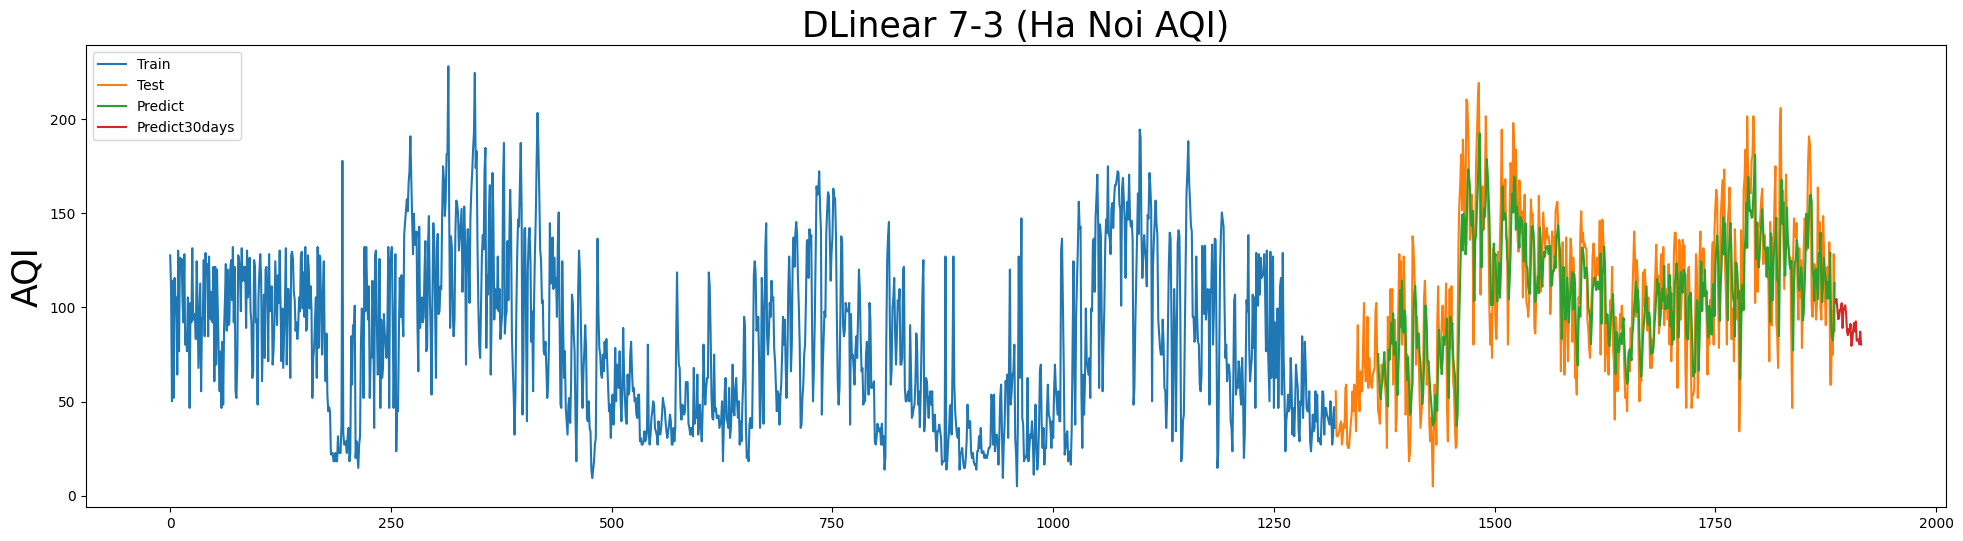

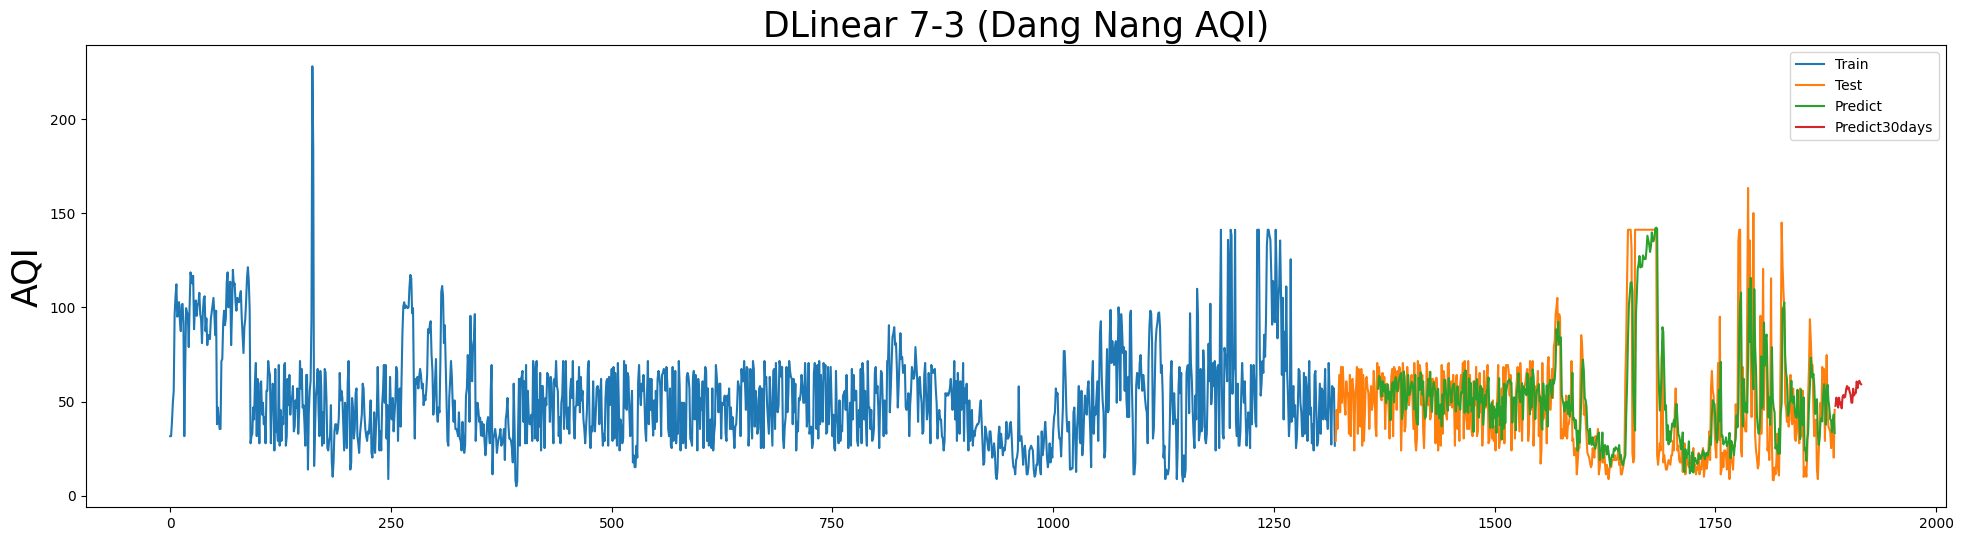

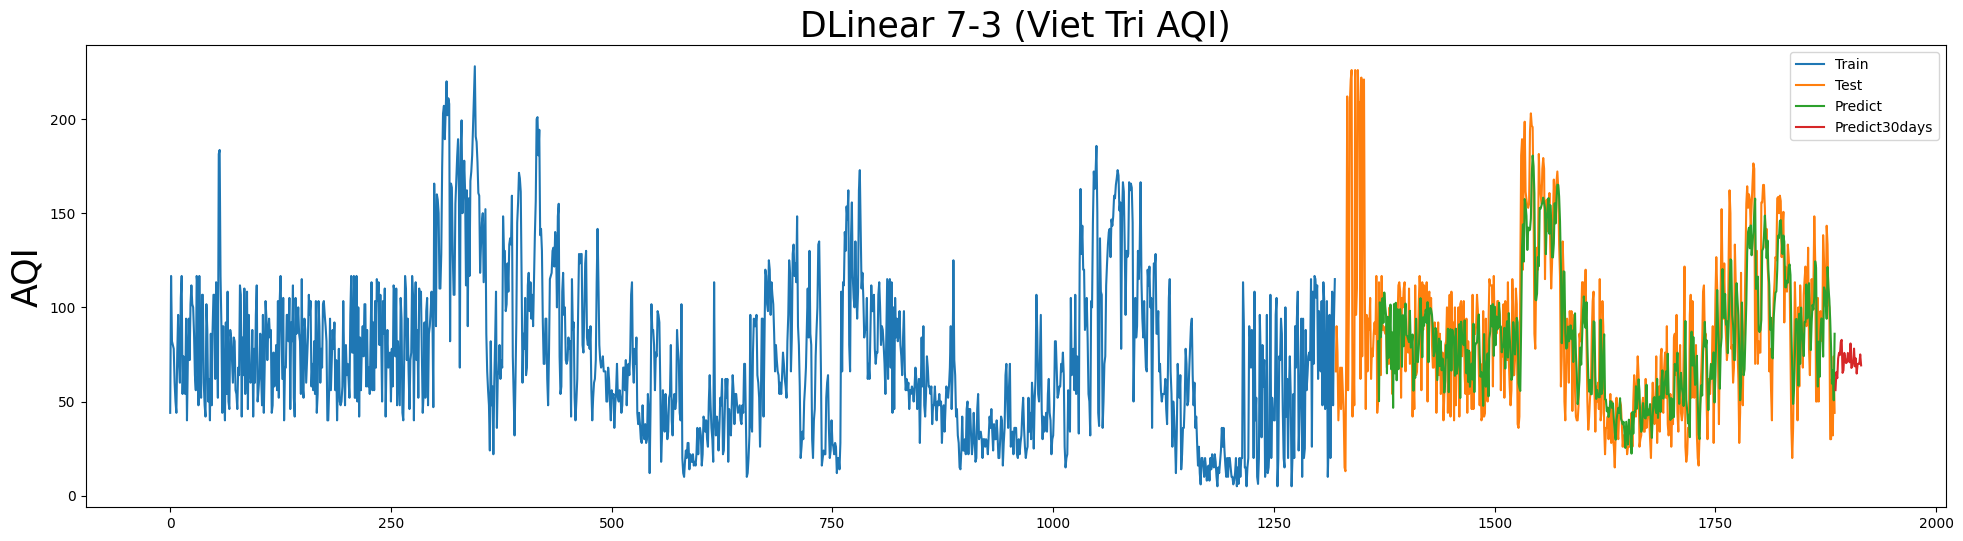

In [14]:
# Visualize the predictions
import matplotlib.pyplot as plt

## HaNoi
train_data_origin = scaler.inverse_transform(train_data_HaNoi)
test_data_origin = scaler.inverse_transform(test_data_HaNoi)
test_pred_origin = test_pred_HaNoi
pred_30_origin = predictions_HaNoi

test_data_index = pd.RangeIndex(start=len(train_data_origin), stop=len(train_data_origin)+len(test_data_origin), step=1)
test_pred_index = pd.RangeIndex(start=len(train_data_origin)+configs.seq_len+configs.pred_len-1, stop=len(train_data_origin)+len(test_data_origin), step=1)
pred_30_index = pd.RangeIndex(start=len(train_data_origin)+len(test_data_origin), stop=len(train_data_origin)+len(test_data_origin)+prediction_days, step=1)

plt.figure(figsize=(24, 6))
plt.title('DLinear 7-3 (Ha Noi AQI)', fontsize=25)
plt.ylabel('AQI', fontsize=25)

plt.plot(train_data_origin)
plt.plot(test_data_index, test_data_origin)
plt.plot(test_pred_index, test_pred_origin)
plt.plot(pred_30_index, pred_30_origin)
plt.legend(['Train','Test','Predict','Predict30days'])

## DaNang
train_data_origin = scaler.inverse_transform(train_data_DaNang)
test_data_origin = scaler.inverse_transform(test_data_DaNang)
test_pred_origin = test_pred_DaNang
pred_30_origin = predictions_DaNang

test_data_index = pd.RangeIndex(start=len(train_data_origin), stop=len(train_data_origin)+len(test_data_origin), step=1)
test_pred_index = pd.RangeIndex(start=len(train_data_origin)+configs.seq_len+configs.pred_len-1, stop=len(train_data_origin)+len(test_data_origin), step=1)
pred_30_index = pd.RangeIndex(start=len(train_data_origin)+len(test_data_origin), stop=len(train_data_origin)+len(test_data_origin)+prediction_days, step=1)

plt.figure(figsize=(24, 6))
plt.title('DLinear 7-3 (Dang Nang AQI)', fontsize=25)
plt.ylabel('AQI', fontsize=25)

plt.plot(train_data_origin)
plt.plot(test_data_index, test_data_origin)
plt.plot(test_pred_index, test_pred_origin)
plt.plot(pred_30_index, pred_30_origin)
plt.legend(['Train','Test','Predict','Predict30days'])

## VietTri
train_data_origin = scaler.inverse_transform(train_data_VietTri)
test_data_origin = scaler.inverse_transform(test_data_VietTri)
test_pred_origin = test_pred_VietTri
pred_30_origin = predictions_VietTri

test_data_index = pd.RangeIndex(start=len(train_data_origin), stop=len(train_data_origin)+len(test_data_origin), step=1)
test_pred_index = pd.RangeIndex(start=len(train_data_origin)+configs.seq_len+configs.pred_len-1, stop=len(train_data_origin)+len(test_data_origin), step=1)
pred_30_index = pd.RangeIndex(start=len(train_data_origin)+len(test_data_origin), stop=len(train_data_origin)+len(test_data_origin)+prediction_days, step=1)

plt.figure(figsize=(24, 6))
plt.title('DLinear 7-3 (Viet Tri AQI)', fontsize=25)
plt.ylabel('AQI', fontsize=25)

plt.plot(train_data_origin)
plt.plot(test_data_index, test_data_origin)
plt.plot(test_pred_index, test_pred_origin)
plt.plot(pred_30_index, pred_30_origin)
plt.legend(['Train','Test','Predict','Predict30days'])



In [15]:
#tính RMSE,MAPE,MAE cho tâp test
from sklearn.metrics import mean_squared_error
from math import sqrt

## HaNoi
print('HaNoi')
test_data_origin = scaler.inverse_transform(test_data_HaNoi)
test_pred_origin = test_pred_HaNoi

test_data_origin_1 = test_data_origin[configs.seq_len+configs.pred_len-1:]
rmse = sqrt(mean_squared_error(test_pred_origin, test_data_origin_1))
mape = np.mean(np.abs((test_pred_origin - test_data_origin_1) /test_data_origin_1)) * 100
mae = np.mean(np.abs(test_pred_origin - test_data_origin_1))
print('Test RMSE: %.3f' % rmse)
print('Test MAPE: %.3f' % mape)
print('Test MAE: %.3f' % mae)

print('DaNang')
test_data_origin = scaler.inverse_transform(test_data_DaNang)
test_pred_origin = test_pred_DaNang

test_data_origin_1 = test_data_origin[configs.seq_len+configs.pred_len-1:]
rmse = sqrt(mean_squared_error(test_pred_origin, test_data_origin_1))
mape = np.mean(np.abs((test_pred_origin - test_data_origin_1) /test_data_origin_1)) * 100
mae = np.mean(np.abs(test_pred_origin - test_data_origin_1))
print('Test RMSE: %.3f' % rmse)
print('Test MAPE: %.3f' % mape)
print('Test MAE: %.3f' % mae)

## VietTri
print('VietTri')
test_data_origin = scaler.inverse_transform(test_data_VietTri)
test_pred_origin = test_pred_VietTri

test_data_origin_1 = test_data_origin[configs.seq_len+configs.pred_len-1:]
rmse = sqrt(mean_squared_error(test_pred_origin, test_data_origin_1))
mape = np.mean(np.abs((test_pred_origin - test_data_origin_1) /test_data_origin_1)) * 100
mae = np.mean(np.abs(test_pred_origin - test_data_origin_1))
print('Test RMSE: %.3f' % rmse)
print('Test MAPE: %.3f' % mape)
print('Test MAE: %.3f' % mae)


HaNoi
Test RMSE: 27.350
Test MAPE: 25.095
Test MAE: 22.130
DaNang
Test RMSE: 22.927
Test MAPE: 49.802
Test MAE: 16.274
VietTri
Test RMSE: 27.257
Test MAPE: 33.551
Test MAE: 21.782


### Với tỉ lệ 8 - 2

In [16]:
#splitting dataset into train and test split
split_size = 0.8

## HaNoi
train_size= int(split_size * len(df_Hanoi))
test_size = int((1-split_size) * len(df_Hanoi))

train_data_HaNoi = df1_HaNoi[:train_size]
test_data_HaNoi = df1_HaNoi[train_size:train_size+test_size]

## DaNang
train_size= int(split_size * len(df_DaNang))
test_size = int((1-split_size) * len(df_DaNang))

train_data_DaNang = df1_DaNang[:train_size]
test_data_DaNang = df1_DaNang[train_size:train_size+test_size]

## VietTri
train_size= int(split_size * len(df_VietTri))
test_size = int((1-split_size) * len(df_VietTri))

train_data_VietTri = df1_VietTri[:train_size]
test_data_VietTri = df1_VietTri[train_size:train_size+test_size]



In [17]:
#train model
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from tqdm import tqdm
# Hyperparameters
seq_len = configs.seq_len  
pred_len =  configs.pred_len
batch_size = 64
num_epochs = 100
learning_rate = 0.003
individual = False


#fit model for HaNoi
model_HaNoi = fit(model, train_data_HaNoi, test_data_HaNoi, seq_len, pred_len, batch_size, num_epochs, learning_rate)

#fit model for DaNang
model_DaNang = fit(model, train_data_DaNang, test_data_DaNang, seq_len, pred_len, batch_size, num_epochs, learning_rate)

#fit model for VietTri
model_VietTri = fit(model, train_data_VietTri, test_data_VietTri, seq_len, pred_len, batch_size, num_epochs, learning_rate)


c:\Users\Hung\miniconda3\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
Epoch [0/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0157] 

Epoch 1/100, Train Loss: 0.0149, Test Loss: 0.0155


Epoch [0/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0157]


Epoch 2/100, Train Loss: 0.0140, Test Loss: 0.0151


Epoch [2/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0116] 

Epoch 3/100, Train Loss: 0.0138, Test Loss: 0.0157


Epoch [2/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0116]


Epoch 4/100, Train Loss: 0.0137, Test Loss: 0.0156


Epoch [4/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0194] 

Epoch 5/100, Train Loss: 0.0137, Test Loss: 0.0155


Epoch [4/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0194]


Epoch 6/100, Train Loss: 0.0137, Test Loss: 0.0174


Epoch [6/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0117]

Epoch 7/100, Train Loss: 0.0138, Test Loss: 0.0157


Epoch [6/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0117]


Epoch 8/100, Train Loss: 0.0143, Test Loss: 0.0155


Epoch [8/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0175] 

Epoch 9/100, Train Loss: 0.0137, Test Loss: 0.0159


Epoch [8/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0175]


Epoch 10/100, Train Loss: 0.0135, Test Loss: 0.0154


Epoch [10/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0127] 

Epoch 11/100, Train Loss: 0.0135, Test Loss: 0.0154


Epoch [10/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0127]


Epoch 12/100, Train Loss: 0.0136, Test Loss: 0.0162


Epoch [12/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0126] 

Epoch 13/100, Train Loss: 0.0136, Test Loss: 0.0158


Epoch [12/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0126]


Epoch 14/100, Train Loss: 0.0135, Test Loss: 0.0157


Epoch [14/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.017] 

Epoch 15/100, Train Loss: 0.0133, Test Loss: 0.0156


Epoch [14/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.017]


Epoch 16/100, Train Loss: 0.0134, Test Loss: 0.0170


Epoch [16/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.017]  

Epoch 17/100, Train Loss: 0.0136, Test Loss: 0.0156


Epoch [16/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.017]


Epoch 18/100, Train Loss: 0.0134, Test Loss: 0.0159


Epoch [18/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0141]

Epoch 19/100, Train Loss: 0.0133, Test Loss: 0.0157


Epoch [18/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0141]


Epoch 20/100, Train Loss: 0.0133, Test Loss: 0.0155


Epoch [20/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0166] 

Epoch 21/100, Train Loss: 0.0133, Test Loss: 0.0155


Epoch [20/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0166]


Epoch 22/100, Train Loss: 0.0132, Test Loss: 0.0155


Epoch [22/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0146] 

Epoch 23/100, Train Loss: 0.0133, Test Loss: 0.0155


Epoch [22/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0146]


Epoch 24/100, Train Loss: 0.0133, Test Loss: 0.0155


Epoch [24/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0107]

Epoch 25/100, Train Loss: 0.0133, Test Loss: 0.0155


Epoch [24/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0107]


Epoch 26/100, Train Loss: 0.0133, Test Loss: 0.0155


Epoch [26/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0129] 

Epoch 27/100, Train Loss: 0.0133, Test Loss: 0.0155


Epoch [26/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0129]


Epoch 28/100, Train Loss: 0.0133, Test Loss: 0.0155


Epoch [28/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0143] 

Epoch 29/100, Train Loss: 0.0133, Test Loss: 0.0155


Epoch [28/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0143]


Epoch 30/100, Train Loss: 0.0133, Test Loss: 0.0155


Epoch [30/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0134] 

Epoch 31/100, Train Loss: 0.0133, Test Loss: 0.0155


Epoch [30/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0134]


Epoch 32/100, Train Loss: 0.0133, Test Loss: 0.0155


Epoch [32/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0119] 

Epoch 33/100, Train Loss: 0.0132, Test Loss: 0.0155


Epoch [32/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0119]


Epoch 34/100, Train Loss: 0.0132, Test Loss: 0.0155


Epoch [34/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0138] 

Epoch 35/100, Train Loss: 0.0133, Test Loss: 0.0155


Epoch [34/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0138]


Epoch 36/100, Train Loss: 0.0132, Test Loss: 0.0155


Epoch [36/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0159] 

Epoch 37/100, Train Loss: 0.0133, Test Loss: 0.0155


Epoch [36/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0159]


Epoch 38/100, Train Loss: 0.0133, Test Loss: 0.0155


Epoch [38/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0113] 

Epoch 39/100, Train Loss: 0.0132, Test Loss: 0.0155


Epoch [38/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0113]


Epoch 40/100, Train Loss: 0.0132, Test Loss: 0.0155


Epoch [40/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0122] 

Epoch 41/100, Train Loss: 0.0133, Test Loss: 0.0155


Epoch [40/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0122]


Epoch 42/100, Train Loss: 0.0133, Test Loss: 0.0155


Epoch [42/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0147]

Epoch 43/100, Train Loss: 0.0133, Test Loss: 0.0155


Epoch [42/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0147]


Epoch 44/100, Train Loss: 0.0133, Test Loss: 0.0155


Epoch [44/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0142] 

Epoch 45/100, Train Loss: 0.0133, Test Loss: 0.0155


Epoch [44/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0142]


Epoch 46/100, Train Loss: 0.0132, Test Loss: 0.0155


Epoch [46/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0105] 

Epoch 47/100, Train Loss: 0.0132, Test Loss: 0.0155


Epoch [46/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0105]


Epoch 48/100, Train Loss: 0.0133, Test Loss: 0.0155


Epoch [48/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0116]

Epoch 49/100, Train Loss: 0.0132, Test Loss: 0.0155


Epoch [48/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0116]


Epoch 50/100, Train Loss: 0.0132, Test Loss: 0.0155


Epoch [50/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0135] 

Epoch 51/100, Train Loss: 0.0133, Test Loss: 0.0155


Epoch [50/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0135]


Epoch 52/100, Train Loss: 0.0132, Test Loss: 0.0155


Epoch [52/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0154] 

Epoch 53/100, Train Loss: 0.0133, Test Loss: 0.0155


Epoch [52/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0154]


Epoch 54/100, Train Loss: 0.0133, Test Loss: 0.0155


Epoch [54/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0158] 

Epoch 55/100, Train Loss: 0.0133, Test Loss: 0.0155


Epoch [54/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0158]


Epoch 56/100, Train Loss: 0.0133, Test Loss: 0.0155


Epoch [56/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.012]  

Epoch 57/100, Train Loss: 0.0132, Test Loss: 0.0155


Epoch [56/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.012]


Epoch 58/100, Train Loss: 0.0132, Test Loss: 0.0155


Epoch [58/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0135] 

Epoch 59/100, Train Loss: 0.0133, Test Loss: 0.0155


Epoch [58/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0135]


Epoch 60/100, Train Loss: 0.0132, Test Loss: 0.0155


Epoch [60/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.011]  

Epoch 61/100, Train Loss: 0.0132, Test Loss: 0.0155


Epoch [60/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.011]


Epoch 62/100, Train Loss: 0.0132, Test Loss: 0.0155


Epoch [62/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.014]  

Epoch 63/100, Train Loss: 0.0133, Test Loss: 0.0155


Epoch [62/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.014]


Epoch 64/100, Train Loss: 0.0132, Test Loss: 0.0155


Epoch [64/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.011]  

Epoch 65/100, Train Loss: 0.0132, Test Loss: 0.0155


Epoch [64/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.011]


Epoch 66/100, Train Loss: 0.0132, Test Loss: 0.0155


Epoch [66/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0172] 

Epoch 67/100, Train Loss: 0.0133, Test Loss: 0.0155


Epoch [66/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0172]


Epoch 68/100, Train Loss: 0.0133, Test Loss: 0.0155


Epoch [68/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0144] 

Epoch 69/100, Train Loss: 0.0133, Test Loss: 0.0155


Epoch [68/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0144]


Epoch 70/100, Train Loss: 0.0133, Test Loss: 0.0155


Epoch [70/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0118] 

Epoch 71/100, Train Loss: 0.0132, Test Loss: 0.0155


Epoch [70/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0118]


Epoch 72/100, Train Loss: 0.0132, Test Loss: 0.0155


Epoch [72/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0128] 

Epoch 73/100, Train Loss: 0.0132, Test Loss: 0.0155


Epoch [72/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0128]


Epoch 74/100, Train Loss: 0.0132, Test Loss: 0.0155


Epoch [74/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0139] 

Epoch 75/100, Train Loss: 0.0133, Test Loss: 0.0155


Epoch [74/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0139]


Epoch 76/100, Train Loss: 0.0132, Test Loss: 0.0155


Epoch [76/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0115] 

Epoch 77/100, Train Loss: 0.0132, Test Loss: 0.0155


Epoch [76/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0115]


Epoch 78/100, Train Loss: 0.0133, Test Loss: 0.0155


Epoch [78/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0068]

Epoch 79/100, Train Loss: 0.0132, Test Loss: 0.0155


Epoch [78/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0068]


Epoch 80/100, Train Loss: 0.0133, Test Loss: 0.0155


Epoch [80/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0122] 

Epoch 81/100, Train Loss: 0.0132, Test Loss: 0.0155


Epoch [80/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0122]


Epoch 82/100, Train Loss: 0.0132, Test Loss: 0.0155


Epoch [82/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0154] 

Epoch 83/100, Train Loss: 0.0133, Test Loss: 0.0155


Epoch [82/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0154]


Epoch 84/100, Train Loss: 0.0133, Test Loss: 0.0155


Epoch [84/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0115] 

Epoch 85/100, Train Loss: 0.0132, Test Loss: 0.0155


Epoch [84/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0115]


Epoch 86/100, Train Loss: 0.0133, Test Loss: 0.0155


Epoch [86/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0112] 

Epoch 87/100, Train Loss: 0.0132, Test Loss: 0.0155


Epoch [86/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0112]


Epoch 88/100, Train Loss: 0.0133, Test Loss: 0.0155


Epoch [88/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0131] 

Epoch 89/100, Train Loss: 0.0133, Test Loss: 0.0155


Epoch [88/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0131]


Epoch 90/100, Train Loss: 0.0133, Test Loss: 0.0155


Epoch [90/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0136] 

Epoch 91/100, Train Loss: 0.0133, Test Loss: 0.0155


Epoch [90/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0136]


Epoch 92/100, Train Loss: 0.0133, Test Loss: 0.0155


Epoch [92/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0179] 

Epoch 93/100, Train Loss: 0.0133, Test Loss: 0.0155


Epoch [92/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0179]


Epoch 94/100, Train Loss: 0.0132, Test Loss: 0.0155


Epoch [94/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0144] 

Epoch 95/100, Train Loss: 0.0133, Test Loss: 0.0155


Epoch [94/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0144]


Epoch 96/100, Train Loss: 0.0133, Test Loss: 0.0155


Epoch [96/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0123] 

Epoch 97/100, Train Loss: 0.0132, Test Loss: 0.0155


Epoch [96/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0123]


Epoch 98/100, Train Loss: 0.0132, Test Loss: 0.0155


Epoch [98/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0141] 

Epoch 99/100, Train Loss: 0.0133, Test Loss: 0.0155


Epoch [99/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00853]


Epoch 100/100, Train Loss: 0.0132, Test Loss: 0.0155


Epoch [0/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0103] 

Epoch 1/100, Train Loss: 0.0077, Test Loss: 0.0119


Epoch [0/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0103]


Epoch 2/100, Train Loss: 0.0072, Test Loss: 0.0128


Epoch [2/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00517]

Epoch 3/100, Train Loss: 0.0070, Test Loss: 0.0127


Epoch [2/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00517]


Epoch 4/100, Train Loss: 0.0070, Test Loss: 0.0128


Epoch [4/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00508]

Epoch 5/100, Train Loss: 0.0072, Test Loss: 0.0127


Epoch [4/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00508]


Epoch 6/100, Train Loss: 0.0069, Test Loss: 0.0128


Epoch [6/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00552]

Epoch 7/100, Train Loss: 0.0068, Test Loss: 0.0132


Epoch [6/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00552]


Epoch 8/100, Train Loss: 0.0068, Test Loss: 0.0129


Epoch [8/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00585]

Epoch 9/100, Train Loss: 0.0067, Test Loss: 0.0131


Epoch [8/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00585]


Epoch 10/100, Train Loss: 0.0068, Test Loss: 0.0129


Epoch [10/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00913]

Epoch 11/100, Train Loss: 0.0069, Test Loss: 0.0129


Epoch [10/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00913]


Epoch 12/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [12/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00639]

Epoch 13/100, Train Loss: 0.0068, Test Loss: 0.0128


Epoch [12/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00639]


Epoch 14/100, Train Loss: 0.0068, Test Loss: 0.0128


Epoch [14/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00637]

Epoch 15/100, Train Loss: 0.0068, Test Loss: 0.0128


Epoch [14/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00637]


Epoch 16/100, Train Loss: 0.0068, Test Loss: 0.0129


Epoch [16/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00753]

Epoch 17/100, Train Loss: 0.0067, Test Loss: 0.0128


Epoch [16/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00753]


Epoch 18/100, Train Loss: 0.0068, Test Loss: 0.0128


Epoch [18/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00804]

Epoch 19/100, Train Loss: 0.0068, Test Loss: 0.0130


Epoch [18/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00804]


Epoch 20/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [20/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00523]

Epoch 21/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [20/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00523]


Epoch 22/100, Train Loss: 0.0068, Test Loss: 0.0128


Epoch [22/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00805]

Epoch 23/100, Train Loss: 0.0068, Test Loss: 0.0129


Epoch [22/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00805]


Epoch 24/100, Train Loss: 0.0067, Test Loss: 0.0128


Epoch [24/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00768]

Epoch 25/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [24/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00768]


Epoch 26/100, Train Loss: 0.0067, Test Loss: 0.0130


Epoch [26/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00721]

Epoch 27/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [26/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00721]


Epoch 28/100, Train Loss: 0.0068, Test Loss: 0.0129


Epoch [28/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00461]

Epoch 29/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [28/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00461]


Epoch 30/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [30/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00867]

Epoch 31/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [30/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00867]


Epoch 32/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [32/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00711]

Epoch 33/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [32/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00711]


Epoch 34/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [34/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00654]

Epoch 35/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [34/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00654]


Epoch 36/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [36/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00513]

Epoch 37/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [36/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00513]


Epoch 38/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [38/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00619]

Epoch 39/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [38/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00619]


Epoch 40/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [40/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0049] 

Epoch 41/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [40/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0049]


Epoch 42/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [42/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00433]

Epoch 43/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [42/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00433]


Epoch 44/100, Train Loss: 0.0068, Test Loss: 0.0129


Epoch [44/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00538]

Epoch 45/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [44/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00538]


Epoch 46/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [46/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00493]

Epoch 47/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [46/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00493]


Epoch 48/100, Train Loss: 0.0068, Test Loss: 0.0129


Epoch [48/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00817]

Epoch 49/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [48/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00817]


Epoch 50/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [50/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00468]

Epoch 51/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [50/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00468]


Epoch 52/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [52/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00659]

Epoch 53/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [52/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00659]


Epoch 54/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [54/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00603]

Epoch 55/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [54/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00603]


Epoch 56/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [56/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00538]

Epoch 57/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [56/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00538]


Epoch 58/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [58/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00613]

Epoch 59/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [58/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00613]


Epoch 60/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [60/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0064] 

Epoch 61/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [60/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0064]


Epoch 62/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [62/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00543]

Epoch 63/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [62/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00543]


Epoch 64/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [64/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0054] 

Epoch 65/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [64/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0054]


Epoch 66/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [66/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0054] 

Epoch 67/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [66/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0054]


Epoch 68/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [68/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00848]

Epoch 69/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [68/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00848]


Epoch 70/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [70/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00605]

Epoch 71/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [70/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00605]


Epoch 72/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [72/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00479]

Epoch 73/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [72/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00479]


Epoch 74/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [74/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00528]

Epoch 75/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [74/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00528]


Epoch 76/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [76/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00632]

Epoch 77/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [76/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00632]


Epoch 78/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [78/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00776]

Epoch 79/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [78/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00776]


Epoch 80/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [80/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.007]  

Epoch 81/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [80/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.007]


Epoch 82/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [82/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00618]

Epoch 83/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [82/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00618]


Epoch 84/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [84/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00671]

Epoch 85/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [84/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00671]


Epoch 86/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [86/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00487]

Epoch 87/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [86/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00487]


Epoch 88/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [88/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0047] 

Epoch 89/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [88/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0047]


Epoch 90/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [90/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0034] 

Epoch 91/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [90/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0034]


Epoch 92/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [92/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00664]

Epoch 93/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [92/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00664]


Epoch 94/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [94/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00474]

Epoch 95/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [94/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00474]


Epoch 96/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [96/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00498]

Epoch 97/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [96/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00498]


Epoch 98/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [98/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00629]

Epoch 99/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [99/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00599]


Epoch 100/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [0/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0234] 

Epoch 1/100, Train Loss: 0.0176, Test Loss: 0.0165


Epoch [0/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0234]


Epoch 2/100, Train Loss: 0.0164, Test Loss: 0.0154


Epoch [2/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0143]

Epoch 3/100, Train Loss: 0.0161, Test Loss: 0.0195


Epoch [2/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0143]


Epoch 4/100, Train Loss: 0.0162, Test Loss: 0.0160


Epoch [4/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0129]

Epoch 5/100, Train Loss: 0.0157, Test Loss: 0.0166


Epoch [4/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0129]


Epoch 6/100, Train Loss: 0.0155, Test Loss: 0.0176


Epoch [6/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0112]

Epoch 7/100, Train Loss: 0.0162, Test Loss: 0.0158


Epoch [6/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0112]


Epoch 8/100, Train Loss: 0.0157, Test Loss: 0.0164


Epoch [8/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0125]

Epoch 9/100, Train Loss: 0.0156, Test Loss: 0.0159


Epoch [8/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0125]


Epoch 10/100, Train Loss: 0.0154, Test Loss: 0.0160


Epoch [10/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0147] 

Epoch 11/100, Train Loss: 0.0154, Test Loss: 0.0159


Epoch [10/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0147]


Epoch 12/100, Train Loss: 0.0154, Test Loss: 0.0163


Epoch [12/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0172] 

Epoch 13/100, Train Loss: 0.0154, Test Loss: 0.0162


Epoch [12/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0172]


Epoch 14/100, Train Loss: 0.0155, Test Loss: 0.0162


Epoch [14/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0129] 

Epoch 15/100, Train Loss: 0.0153, Test Loss: 0.0166


Epoch [14/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0129]


Epoch 16/100, Train Loss: 0.0154, Test Loss: 0.0165


Epoch [16/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.012] 

Epoch 17/100, Train Loss: 0.0155, Test Loss: 0.0164


Epoch [16/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.012]


Epoch 18/100, Train Loss: 0.0155, Test Loss: 0.0165


Epoch [18/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0162] 

Epoch 19/100, Train Loss: 0.0156, Test Loss: 0.0160


Epoch [18/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0162]


Epoch 20/100, Train Loss: 0.0154, Test Loss: 0.0162


Epoch [20/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0174] 

Epoch 21/100, Train Loss: 0.0153, Test Loss: 0.0160


Epoch [20/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0174]


Epoch 22/100, Train Loss: 0.0153, Test Loss: 0.0162


Epoch [22/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0128] 

Epoch 23/100, Train Loss: 0.0153, Test Loss: 0.0159


Epoch [22/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0128]


Epoch 24/100, Train Loss: 0.0153, Test Loss: 0.0162


Epoch [24/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0124] 

Epoch 25/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [24/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0124]


Epoch 26/100, Train Loss: 0.0153, Test Loss: 0.0163


Epoch [26/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0237]

Epoch 27/100, Train Loss: 0.0153, Test Loss: 0.0161


Epoch [26/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0237]


Epoch 28/100, Train Loss: 0.0153, Test Loss: 0.0162


Epoch [28/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0202]

Epoch 29/100, Train Loss: 0.0153, Test Loss: 0.0161


Epoch [28/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0202]


Epoch 30/100, Train Loss: 0.0152, Test Loss: 0.0161


Epoch [30/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.016] 

Epoch 31/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [30/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.016]


Epoch 32/100, Train Loss: 0.0153, Test Loss: 0.0161


Epoch [32/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.015] 

Epoch 33/100, Train Loss: 0.0152, Test Loss: 0.0161


Epoch [32/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.015]


Epoch 34/100, Train Loss: 0.0152, Test Loss: 0.0161


Epoch [34/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00987]

Epoch 35/100, Train Loss: 0.0152, Test Loss: 0.0161


Epoch [34/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00987]


Epoch 36/100, Train Loss: 0.0153, Test Loss: 0.0162


Epoch [36/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0119] 

Epoch 37/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [36/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0119]


Epoch 38/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [38/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0147] 

Epoch 39/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [38/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0147]


Epoch 40/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [40/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0118] 

Epoch 41/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [40/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0118]


Epoch 42/100, Train Loss: 0.0152, Test Loss: 0.0161


Epoch [42/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0142] 

Epoch 43/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [42/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0142]


Epoch 44/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [44/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0173] 

Epoch 45/100, Train Loss: 0.0152, Test Loss: 0.0161


Epoch [44/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0173]


Epoch 46/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [46/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0185]

Epoch 47/100, Train Loss: 0.0152, Test Loss: 0.0161


Epoch [46/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0185]


Epoch 48/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [48/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0262] 

Epoch 49/100, Train Loss: 0.0153, Test Loss: 0.0162


Epoch [48/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0262]


Epoch 50/100, Train Loss: 0.0153, Test Loss: 0.0162


Epoch [50/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0134] 

Epoch 51/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [50/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0134]


Epoch 52/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [52/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0226]

Epoch 53/100, Train Loss: 0.0153, Test Loss: 0.0162


Epoch [52/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0226]


Epoch 54/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [54/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0147] 

Epoch 55/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [54/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0147]


Epoch 56/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [56/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.019] 

Epoch 57/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [56/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.019]


Epoch 58/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [58/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0186]

Epoch 59/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [58/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0186]


Epoch 60/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [60/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0131] 

Epoch 61/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [60/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0131]


Epoch 62/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [62/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0149] 

Epoch 63/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [62/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0149]


Epoch 64/100, Train Loss: 0.0153, Test Loss: 0.0162


Epoch [64/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0126]

Epoch 65/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [64/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0126]


Epoch 66/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [66/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0107]

Epoch 67/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [66/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0107]


Epoch 68/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [68/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0197] 

Epoch 69/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [68/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0197]


Epoch 70/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [70/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0143] 

Epoch 71/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [70/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0143]


Epoch 72/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [72/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.01]   

Epoch 73/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [72/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.01]


Epoch 74/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [74/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0131]

Epoch 75/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [74/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0131]


Epoch 76/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [76/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0163]

Epoch 77/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [76/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0163]


Epoch 78/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [78/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0216]

Epoch 79/100, Train Loss: 0.0153, Test Loss: 0.0162


Epoch [78/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0216]


Epoch 80/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [80/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0111] 

Epoch 81/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [80/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0111]


Epoch 82/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [82/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0155] 

Epoch 83/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [82/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0155]


Epoch 84/100, Train Loss: 0.0153, Test Loss: 0.0162


Epoch [84/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0173] 

Epoch 85/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [84/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0173]


Epoch 86/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [86/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0113] 

Epoch 87/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [86/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0113]


Epoch 88/100, Train Loss: 0.0153, Test Loss: 0.0162


Epoch [88/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.02]  

Epoch 89/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [88/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.02]


Epoch 90/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [90/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0169]

Epoch 91/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [90/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0169]


Epoch 92/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [92/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0228] 

Epoch 93/100, Train Loss: 0.0153, Test Loss: 0.0162


Epoch [92/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0228]


Epoch 94/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [94/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0156]

Epoch 95/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [94/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0156]


Epoch 96/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [96/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0184]

Epoch 97/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [96/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0184]


Epoch 98/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [98/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.014]  

Epoch 99/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [99/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0107]

Epoch 100/100, Train Loss: 0.0152, Test Loss: 0.0162


In [18]:
# Make predictions on the test data
test_pred_HaNoi = predict_test(model_HaNoi, test_data_HaNoi, seq_len, pred_len, batch_size)
test_pred_DaNang = predict_test(model_DaNang, test_data_DaNang, seq_len, pred_len, batch_size)
test_pred_VietTri = predict_test(model_VietTri, test_data_VietTri, seq_len, pred_len, batch_size)
# Inverse transform the predictions
test_pred_HaNoi = scaler.inverse_transform(test_pred_HaNoi)
test_pred_DaNang = scaler.inverse_transform(test_pred_DaNang)
test_pred_VietTri = scaler.inverse_transform(test_pred_VietTri)


In [19]:
# Make predictions for the next 30 days
prediction_days = 30
predictions_HaNoi = predict_30(model_HaNoi, test_data_HaNoi, configs.seq_len, prediction_days)
predictions_DaNang = predict_30(model_DaNang, test_data_DaNang, configs.seq_len, prediction_days)
predictions_VietTri = predict_30(model_VietTri, test_data_VietTri, configs.seq_len, prediction_days)

# Inverse transform the predictions
predictions_HaNoi = scaler.inverse_transform(predictions_HaNoi)
predictions_DaNang = scaler.inverse_transform(predictions_DaNang)
predictions_VietTri = scaler.inverse_transform(predictions_VietTri)


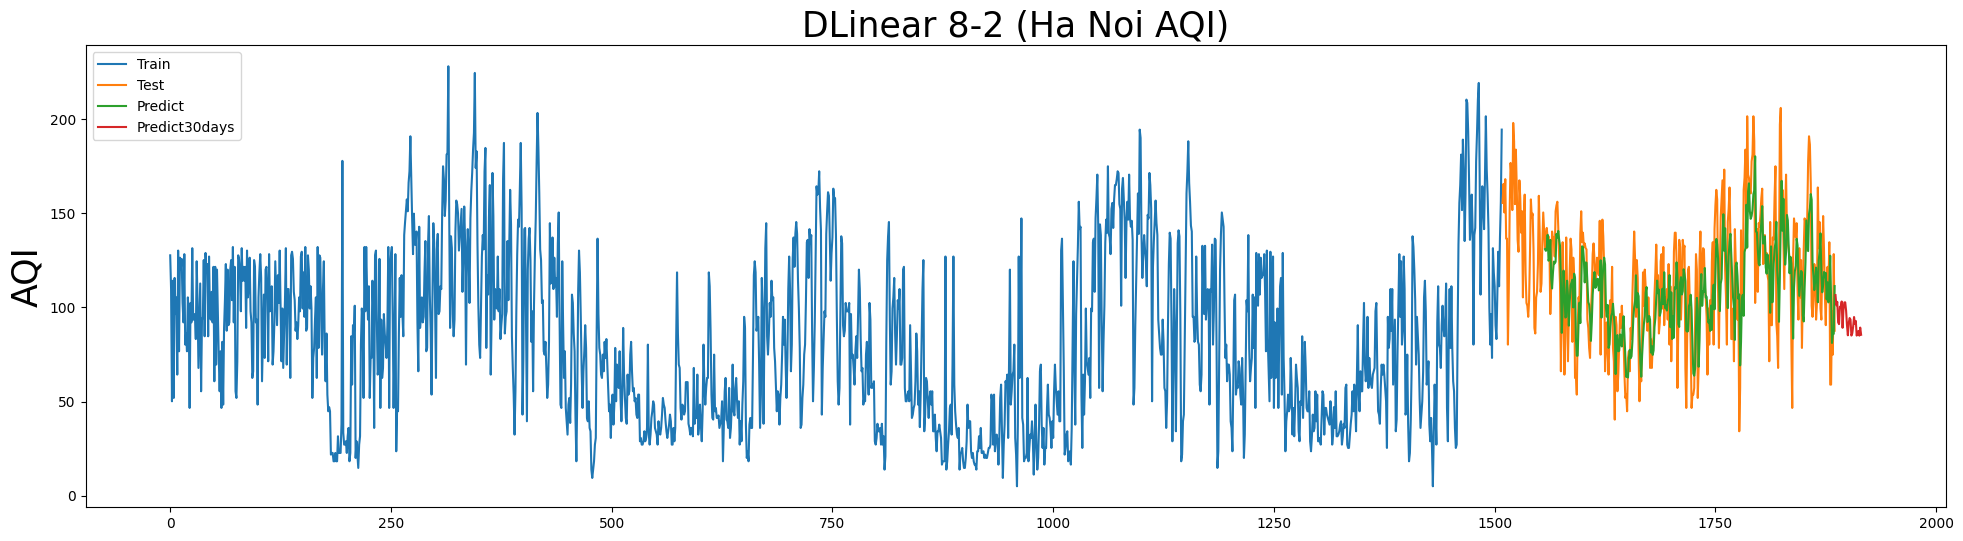

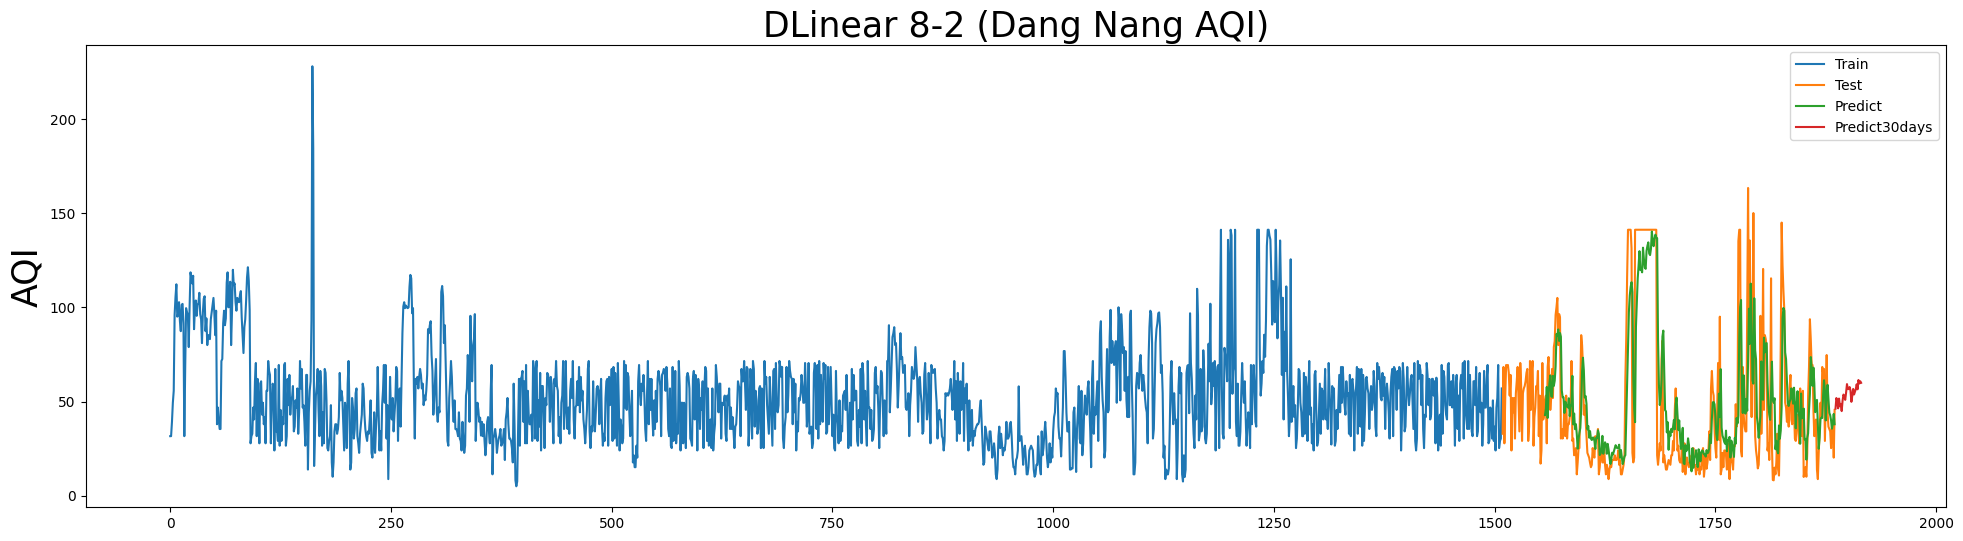

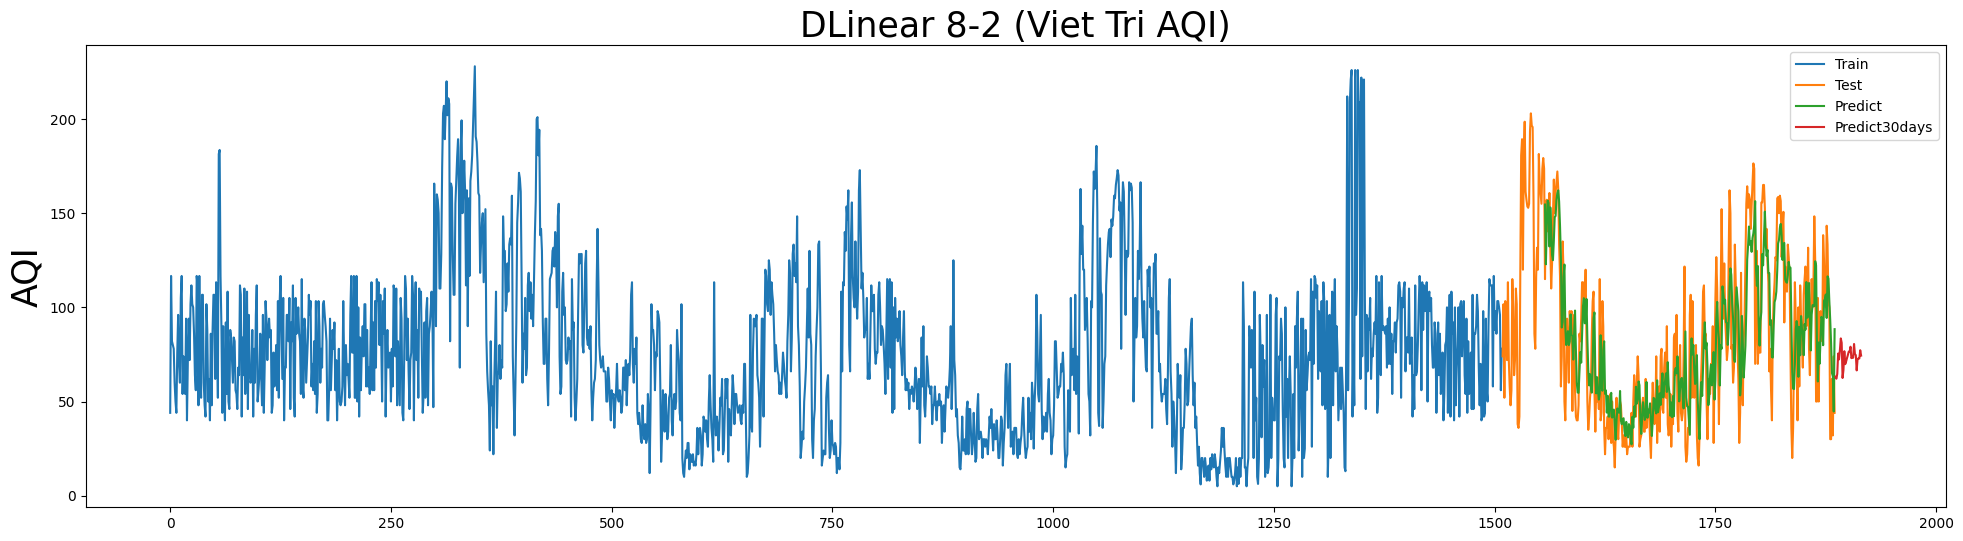

In [20]:
# Visualize the predictions
import matplotlib.pyplot as plt

## HaNoi
train_data_origin = scaler.inverse_transform(train_data_HaNoi)
test_data_origin = scaler.inverse_transform(test_data_HaNoi)
test_pred_origin = test_pred_HaNoi
pred_30_origin = predictions_HaNoi

test_data_index = pd.RangeIndex(start=len(train_data_origin), stop=len(train_data_origin)+len(test_data_origin), step=1)
test_pred_index = pd.RangeIndex(start=len(train_data_origin)+configs.seq_len+configs.pred_len-1, stop=len(train_data_origin)+len(test_data_origin), step=1)
pred_30_index = pd.RangeIndex(start=len(train_data_origin)+len(test_data_origin), stop=len(train_data_origin)+len(test_data_origin)+prediction_days, step=1)

plt.figure(figsize=(24, 6))
plt.title('DLinear 8-2 (Ha Noi AQI)', fontsize=25)
plt.ylabel('AQI', fontsize=25)

plt.plot(train_data_origin)
plt.plot(test_data_index, test_data_origin)
plt.plot(test_pred_index, test_pred_origin)
plt.plot(pred_30_index, pred_30_origin)
plt.legend(['Train','Test','Predict','Predict30days'])

## DaNang
train_data_origin = scaler.inverse_transform(train_data_DaNang)
test_data_origin = scaler.inverse_transform(test_data_DaNang)
test_pred_origin = test_pred_DaNang
pred_30_origin = predictions_DaNang

test_data_index = pd.RangeIndex(start=len(train_data_origin), stop=len(train_data_origin)+len(test_data_origin), step=1)
test_pred_index = pd.RangeIndex(start=len(train_data_origin)+configs.seq_len+configs.pred_len-1, stop=len(train_data_origin)+len(test_data_origin), step=1)
pred_30_index = pd.RangeIndex(start=len(train_data_origin)+len(test_data_origin), stop=len(train_data_origin)+len(test_data_origin)+prediction_days, step=1)

plt.figure(figsize=(24, 6))
plt.title('DLinear 8-2 (Dang Nang AQI)', fontsize=25)
plt.ylabel('AQI', fontsize=25)

plt.plot(train_data_origin)
plt.plot(test_data_index, test_data_origin)
plt.plot(test_pred_index, test_pred_origin)
plt.plot(pred_30_index, pred_30_origin)
plt.legend(['Train','Test','Predict','Predict30days'])

## VietTri
train_data_origin = scaler.inverse_transform(train_data_VietTri)
test_data_origin = scaler.inverse_transform(test_data_VietTri)
test_pred_origin = test_pred_VietTri
pred_30_origin = predictions_VietTri

test_data_index = pd.RangeIndex(start=len(train_data_origin), stop=len(train_data_origin)+len(test_data_origin), step=1)
test_pred_index = pd.RangeIndex(start=len(train_data_origin)+configs.seq_len+configs.pred_len-1, stop=len(train_data_origin)+len(test_data_origin), step=1)
pred_30_index = pd.RangeIndex(start=len(train_data_origin)+len(test_data_origin), stop=len(train_data_origin)+len(test_data_origin)+prediction_days, step=1)

plt.figure(figsize=(24, 6))
plt.title('DLinear 8-2 (Viet Tri AQI)', fontsize=25)
plt.ylabel('AQI', fontsize=25)

plt.plot(train_data_origin)
plt.plot(test_data_index, test_data_origin)
plt.plot(test_pred_index, test_pred_origin)
plt.plot(pred_30_index, pred_30_origin)
plt.legend(['Train','Test','Predict','Predict30days'])



In [21]:
#tính RMSE,MAPE,MAE cho tâp test
from sklearn.metrics import mean_squared_error
from math import sqrt

## HaNoi
print('HaNoi')
test_data_origin = scaler.inverse_transform(test_data_HaNoi)
test_pred_origin = test_pred_HaNoi

test_data_origin_1 = test_data_origin[configs.seq_len+configs.pred_len-1:]
rmse = sqrt(mean_squared_error(test_pred_origin, test_data_origin_1))
mape = np.mean(np.abs((test_pred_origin - test_data_origin_1) /test_data_origin_1)) * 100
mae = np.mean(np.abs(test_pred_origin - test_data_origin_1))
print('Test RMSE: %.3f' % rmse)
print('Test MAPE: %.3f' % mape)
print('Test MAE: %.3f' % mae)

print('DaNang')
test_data_origin = scaler.inverse_transform(test_data_DaNang)
test_pred_origin = test_pred_DaNang

test_data_origin_1 = test_data_origin[configs.seq_len+configs.pred_len-1:]
rmse = sqrt(mean_squared_error(test_pred_origin, test_data_origin_1))
mape = np.mean(np.abs((test_pred_origin - test_data_origin_1) /test_data_origin_1)) * 100
mae = np.mean(np.abs(test_pred_origin - test_data_origin_1))
print('Test RMSE: %.3f' % rmse)
print('Test MAPE: %.3f' % mape)
print('Test MAE: %.3f' % mae)

## VietTri
print('VietTri')
test_data_origin = scaler.inverse_transform(test_data_VietTri)
test_pred_origin = test_pred_VietTri

test_data_origin_1 = test_data_origin[configs.seq_len+configs.pred_len-1:]
rmse = sqrt(mean_squared_error(test_pred_origin, test_data_origin_1))
mape = np.mean(np.abs((test_pred_origin - test_data_origin_1) /test_data_origin_1)) * 100
mae = np.mean(np.abs(test_pred_origin - test_data_origin_1))
print('Test RMSE: %.3f' % rmse)
print('Test MAPE: %.3f' % mape)
print('Test MAE: %.3f' % mae)


HaNoi
Test RMSE: 27.281
Test MAPE: 22.180
Test MAE: 21.974
DaNang
Test RMSE: 26.030
Test MAPE: 61.039
Test MAE: 18.242
VietTri
Test RMSE: 27.122
Test MAPE: 37.032
Test MAE: 21.712


### Với tỉ lệ 9 - 1

In [22]:
#splitting dataset into train and test split
split_size = 0.9

## HaNoi
train_size= int(split_size * len(df_Hanoi))
test_size = int((1-split_size) * len(df_Hanoi))

train_data_HaNoi = df1_HaNoi[:train_size]
test_data_HaNoi = df1_HaNoi[train_size:train_size+test_size]

## DaNang
train_size= int(split_size * len(df_DaNang))
test_size = int((1-split_size) * len(df_DaNang))

train_data_DaNang = df1_DaNang[:train_size]
test_data_DaNang = df1_DaNang[train_size:train_size+test_size]

## VietTri
train_size= int(split_size * len(df_VietTri))
test_size = int((1-split_size) * len(df_VietTri))

train_data_VietTri = df1_VietTri[:train_size]
test_data_VietTri = df1_VietTri[train_size:train_size+test_size]



In [23]:
#train model
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from tqdm import tqdm
# Hyperparameters
seq_len = configs.seq_len  
pred_len =  configs.pred_len
batch_size = 64
num_epochs = 100
learning_rate = 0.003
individual = False


#fit model for HaNoi
model_HaNoi = fit(model, train_data_HaNoi, test_data_HaNoi, seq_len, pred_len, batch_size, num_epochs, learning_rate)

#fit model for DaNang
model_DaNang = fit(model, train_data_DaNang, test_data_DaNang, seq_len, pred_len, batch_size, num_epochs, learning_rate)

#fit model for VietTri
model_VietTri = fit(model, train_data_VietTri, test_data_VietTri, seq_len, pred_len, batch_size, num_epochs, learning_rate)


c:\Users\Hung\miniconda3\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
Epoch [0/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00743]

Epoch 1/100, Train Loss: 0.0146, Test Loss: 0.0216


Epoch [0/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00743]


Epoch 2/100, Train Loss: 0.0138, Test Loss: 0.0190


Epoch [2/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0118] 

Epoch 3/100, Train Loss: 0.0132, Test Loss: 0.0201


Epoch [2/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0118]


Epoch 4/100, Train Loss: 0.0133, Test Loss: 0.0190


Epoch [4/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0163] 

Epoch 5/100, Train Loss: 0.0131, Test Loss: 0.0197


Epoch [4/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0163]


Epoch 6/100, Train Loss: 0.0132, Test Loss: 0.0199


Epoch [6/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0107] 

Epoch 7/100, Train Loss: 0.0132, Test Loss: 0.0194


Epoch [6/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0107]


Epoch 8/100, Train Loss: 0.0132, Test Loss: 0.0192


Epoch [8/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0132] 

Epoch 9/100, Train Loss: 0.0132, Test Loss: 0.0192


Epoch [8/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0132]


Epoch 10/100, Train Loss: 0.0130, Test Loss: 0.0193


Epoch [10/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0124] 

Epoch 11/100, Train Loss: 0.0129, Test Loss: 0.0193


Epoch [10/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0124]


Epoch 12/100, Train Loss: 0.0129, Test Loss: 0.0192


Epoch [12/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0107] 

Epoch 13/100, Train Loss: 0.0130, Test Loss: 0.0193


Epoch [12/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0107]


Epoch 14/100, Train Loss: 0.0129, Test Loss: 0.0197


Epoch [14/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0202] 

Epoch 15/100, Train Loss: 0.0131, Test Loss: 0.0196


Epoch [14/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0202]


Epoch 16/100, Train Loss: 0.0130, Test Loss: 0.0193


Epoch [16/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0122] 

Epoch 17/100, Train Loss: 0.0128, Test Loss: 0.0193


Epoch [16/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0122]


Epoch 18/100, Train Loss: 0.0129, Test Loss: 0.0193


Epoch [18/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00817]

Epoch 19/100, Train Loss: 0.0128, Test Loss: 0.0193


Epoch [18/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00817]


Epoch 20/100, Train Loss: 0.0129, Test Loss: 0.0194


Epoch [20/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.011]  

Epoch 21/100, Train Loss: 0.0129, Test Loss: 0.0194


Epoch [20/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.011]


Epoch 22/100, Train Loss: 0.0129, Test Loss: 0.0193


Epoch [22/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00701]

Epoch 23/100, Train Loss: 0.0127, Test Loss: 0.0193


Epoch [22/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00701]


Epoch 24/100, Train Loss: 0.0128, Test Loss: 0.0193


Epoch [24/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00953]

Epoch 25/100, Train Loss: 0.0128, Test Loss: 0.0193


Epoch [24/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00953]


Epoch 26/100, Train Loss: 0.0128, Test Loss: 0.0193


Epoch [26/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0122] 

Epoch 27/100, Train Loss: 0.0128, Test Loss: 0.0193


Epoch [26/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0122]


Epoch 28/100, Train Loss: 0.0128, Test Loss: 0.0193


Epoch [28/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.013]  

Epoch 29/100, Train Loss: 0.0128, Test Loss: 0.0193


Epoch [28/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.013]


Epoch 30/100, Train Loss: 0.0127, Test Loss: 0.0193


Epoch [30/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0132] 

Epoch 31/100, Train Loss: 0.0128, Test Loss: 0.0193


Epoch [30/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0132]


Epoch 32/100, Train Loss: 0.0128, Test Loss: 0.0193


Epoch [32/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0107] 

Epoch 33/100, Train Loss: 0.0128, Test Loss: 0.0193


Epoch [32/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0107]


Epoch 34/100, Train Loss: 0.0127, Test Loss: 0.0193


Epoch [34/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00846]

Epoch 35/100, Train Loss: 0.0127, Test Loss: 0.0193


Epoch [34/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00846]


Epoch 36/100, Train Loss: 0.0128, Test Loss: 0.0193


Epoch [36/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0177] 

Epoch 37/100, Train Loss: 0.0128, Test Loss: 0.0193


Epoch [36/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0177]


Epoch 38/100, Train Loss: 0.0128, Test Loss: 0.0193


Epoch [38/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00848]

Epoch 39/100, Train Loss: 0.0127, Test Loss: 0.0193


Epoch [38/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00848]


Epoch 40/100, Train Loss: 0.0128, Test Loss: 0.0193


Epoch [40/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0103] 

Epoch 41/100, Train Loss: 0.0127, Test Loss: 0.0193


Epoch [40/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0103]


Epoch 42/100, Train Loss: 0.0128, Test Loss: 0.0193


Epoch [42/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0161] 

Epoch 43/100, Train Loss: 0.0128, Test Loss: 0.0193


Epoch [42/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0161]


Epoch 44/100, Train Loss: 0.0128, Test Loss: 0.0193


Epoch [44/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0193] 

Epoch 45/100, Train Loss: 0.0128, Test Loss: 0.0193


Epoch [44/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0193]


Epoch 46/100, Train Loss: 0.0128, Test Loss: 0.0193


Epoch [46/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00892]

Epoch 47/100, Train Loss: 0.0127, Test Loss: 0.0193


Epoch [46/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00892]


Epoch 48/100, Train Loss: 0.0127, Test Loss: 0.0193


Epoch [48/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0129] 

Epoch 49/100, Train Loss: 0.0128, Test Loss: 0.0193


Epoch [48/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0129]


Epoch 50/100, Train Loss: 0.0128, Test Loss: 0.0193


Epoch [50/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0158] 

Epoch 51/100, Train Loss: 0.0128, Test Loss: 0.0193


Epoch [50/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0158]


Epoch 52/100, Train Loss: 0.0128, Test Loss: 0.0193


Epoch [52/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0149] 

Epoch 53/100, Train Loss: 0.0128, Test Loss: 0.0193


Epoch [52/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0149]


Epoch 54/100, Train Loss: 0.0127, Test Loss: 0.0193


Epoch [54/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0201] 

Epoch 55/100, Train Loss: 0.0128, Test Loss: 0.0193


Epoch [54/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0201]


Epoch 56/100, Train Loss: 0.0128, Test Loss: 0.0193


Epoch [56/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0139] 

Epoch 57/100, Train Loss: 0.0128, Test Loss: 0.0193


Epoch [56/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0139]


Epoch 58/100, Train Loss: 0.0128, Test Loss: 0.0193


Epoch [58/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0111] 

Epoch 59/100, Train Loss: 0.0127, Test Loss: 0.0193


Epoch [58/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0111]


Epoch 60/100, Train Loss: 0.0127, Test Loss: 0.0193


Epoch [60/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0123] 

Epoch 61/100, Train Loss: 0.0127, Test Loss: 0.0193


Epoch [60/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0123]


Epoch 62/100, Train Loss: 0.0127, Test Loss: 0.0193


Epoch [62/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0107] 

Epoch 63/100, Train Loss: 0.0127, Test Loss: 0.0193


Epoch [62/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0107]


Epoch 64/100, Train Loss: 0.0128, Test Loss: 0.0193


Epoch [64/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0162] 

Epoch 65/100, Train Loss: 0.0128, Test Loss: 0.0193


Epoch [64/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0162]


Epoch 66/100, Train Loss: 0.0127, Test Loss: 0.0193


Epoch [66/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0162] 

Epoch 67/100, Train Loss: 0.0128, Test Loss: 0.0193


Epoch [66/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0162]


Epoch 68/100, Train Loss: 0.0128, Test Loss: 0.0193


Epoch [68/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0111]

Epoch 69/100, Train Loss: 0.0127, Test Loss: 0.0193


Epoch [68/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0111]


Epoch 70/100, Train Loss: 0.0128, Test Loss: 0.0193


Epoch [70/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0132] 

Epoch 71/100, Train Loss: 0.0128, Test Loss: 0.0193


Epoch [70/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0132]


Epoch 72/100, Train Loss: 0.0127, Test Loss: 0.0193


Epoch [72/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0109] 

Epoch 73/100, Train Loss: 0.0127, Test Loss: 0.0193


Epoch [72/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0109]


Epoch 74/100, Train Loss: 0.0128, Test Loss: 0.0193


Epoch [74/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0104] 

Epoch 75/100, Train Loss: 0.0127, Test Loss: 0.0193


Epoch [74/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0104]


Epoch 76/100, Train Loss: 0.0128, Test Loss: 0.0193


Epoch [76/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0227] 

Epoch 77/100, Train Loss: 0.0128, Test Loss: 0.0193


Epoch [76/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0227]


Epoch 78/100, Train Loss: 0.0127, Test Loss: 0.0193


Epoch [78/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0135] 

Epoch 79/100, Train Loss: 0.0128, Test Loss: 0.0193


Epoch [78/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0135]


Epoch 80/100, Train Loss: 0.0127, Test Loss: 0.0193


Epoch [80/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.012]  

Epoch 81/100, Train Loss: 0.0127, Test Loss: 0.0193


Epoch [80/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.012]


Epoch 82/100, Train Loss: 0.0127, Test Loss: 0.0193


Epoch [82/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0119] 

Epoch 83/100, Train Loss: 0.0127, Test Loss: 0.0193


Epoch [82/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0119]


Epoch 84/100, Train Loss: 0.0128, Test Loss: 0.0193


Epoch [84/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0128] 

Epoch 85/100, Train Loss: 0.0127, Test Loss: 0.0193


Epoch [84/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0128]


Epoch 86/100, Train Loss: 0.0128, Test Loss: 0.0193


Epoch [86/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0102] 

Epoch 87/100, Train Loss: 0.0127, Test Loss: 0.0193


Epoch [86/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0102]


Epoch 88/100, Train Loss: 0.0127, Test Loss: 0.0193


Epoch [88/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0153] 

Epoch 89/100, Train Loss: 0.0128, Test Loss: 0.0193


Epoch [88/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0153]


Epoch 90/100, Train Loss: 0.0127, Test Loss: 0.0193


Epoch [90/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0173] 

Epoch 91/100, Train Loss: 0.0128, Test Loss: 0.0193


Epoch [90/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0173]


Epoch 92/100, Train Loss: 0.0128, Test Loss: 0.0193


Epoch [92/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00914]

Epoch 93/100, Train Loss: 0.0127, Test Loss: 0.0193


Epoch [92/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00914]


Epoch 94/100, Train Loss: 0.0128, Test Loss: 0.0193


Epoch [94/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0137] 

Epoch 95/100, Train Loss: 0.0128, Test Loss: 0.0193


Epoch [94/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0137]


Epoch 96/100, Train Loss: 0.0128, Test Loss: 0.0193


Epoch [96/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0127] 

Epoch 97/100, Train Loss: 0.0127, Test Loss: 0.0193


Epoch [96/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0127]


Epoch 98/100, Train Loss: 0.0128, Test Loss: 0.0193


Epoch [98/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0124] 

Epoch 99/100, Train Loss: 0.0127, Test Loss: 0.0193


Epoch [99/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.015]


Epoch 100/100, Train Loss: 0.0128, Test Loss: 0.0193


Epoch [0/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00533]

Epoch 1/100, Train Loss: 0.0078, Test Loss: 0.0143


Epoch [0/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00533]


Epoch 2/100, Train Loss: 0.0076, Test Loss: 0.0143


Epoch [2/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0073] 

Epoch 3/100, Train Loss: 0.0075, Test Loss: 0.0144


Epoch [2/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0073]


Epoch 4/100, Train Loss: 0.0076, Test Loss: 0.0145


Epoch [4/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00582]

Epoch 5/100, Train Loss: 0.0075, Test Loss: 0.0145


Epoch [4/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00582]


Epoch 6/100, Train Loss: 0.0074, Test Loss: 0.0147


Epoch [6/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0075] 

Epoch 7/100, Train Loss: 0.0075, Test Loss: 0.0145


Epoch [6/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0075]


Epoch 8/100, Train Loss: 0.0074, Test Loss: 0.0150


Epoch [8/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00749]

Epoch 9/100, Train Loss: 0.0073, Test Loss: 0.0146


Epoch [8/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00749]


Epoch 10/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [10/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00681]

Epoch 11/100, Train Loss: 0.0073, Test Loss: 0.0146


Epoch [10/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00681]


Epoch 12/100, Train Loss: 0.0073, Test Loss: 0.0147


Epoch [12/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00724]

Epoch 13/100, Train Loss: 0.0073, Test Loss: 0.0150


Epoch [12/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00724]


Epoch 14/100, Train Loss: 0.0073, Test Loss: 0.0148


Epoch [14/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00457]

Epoch 15/100, Train Loss: 0.0072, Test Loss: 0.0149


Epoch [14/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00457]


Epoch 16/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [16/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00669]

Epoch 17/100, Train Loss: 0.0072, Test Loss: 0.0145


Epoch [16/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00669]


Epoch 18/100, Train Loss: 0.0073, Test Loss: 0.0145


Epoch [18/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00962]

Epoch 19/100, Train Loss: 0.0073, Test Loss: 0.0146


Epoch [18/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00962]


Epoch 20/100, Train Loss: 0.0072, Test Loss: 0.0149


Epoch [20/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00426]

Epoch 21/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [20/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00426]


Epoch 22/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [22/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00418]

Epoch 23/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [22/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00418]


Epoch 24/100, Train Loss: 0.0072, Test Loss: 0.0147


Epoch [24/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00599]

Epoch 25/100, Train Loss: 0.0073, Test Loss: 0.0147


Epoch [24/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00599]


Epoch 26/100, Train Loss: 0.0072, Test Loss: 0.0147


Epoch [26/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00648]

Epoch 27/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [26/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00648]


Epoch 28/100, Train Loss: 0.0072, Test Loss: 0.0147


Epoch [28/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00623]

Epoch 29/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [28/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00623]


Epoch 30/100, Train Loss: 0.0072, Test Loss: 0.0147


Epoch [30/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00636]

Epoch 31/100, Train Loss: 0.0072, Test Loss: 0.0147


Epoch [30/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00636]


Epoch 32/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [32/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00558]

Epoch 33/100, Train Loss: 0.0072, Test Loss: 0.0147


Epoch [32/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00558]


Epoch 34/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [34/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00675]

Epoch 35/100, Train Loss: 0.0072, Test Loss: 0.0147


Epoch [34/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00675]


Epoch 36/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [36/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00622]

Epoch 37/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [36/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00622]


Epoch 38/100, Train Loss: 0.0073, Test Loss: 0.0147


Epoch [38/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00653]

Epoch 39/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [38/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00653]


Epoch 40/100, Train Loss: 0.0072, Test Loss: 0.0147


Epoch [40/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00523]

Epoch 41/100, Train Loss: 0.0072, Test Loss: 0.0147


Epoch [40/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00523]


Epoch 42/100, Train Loss: 0.0072, Test Loss: 0.0147


Epoch [42/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0112] 

Epoch 43/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [42/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0112]


Epoch 44/100, Train Loss: 0.0072, Test Loss: 0.0147


Epoch [44/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00701]

Epoch 45/100, Train Loss: 0.0072, Test Loss: 0.0147


Epoch [44/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00701]


Epoch 46/100, Train Loss: 0.0073, Test Loss: 0.0146


Epoch [46/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00786]

Epoch 47/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [46/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00786]


Epoch 48/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [48/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00594]

Epoch 49/100, Train Loss: 0.0072, Test Loss: 0.0147


Epoch [48/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00594]


Epoch 50/100, Train Loss: 0.0072, Test Loss: 0.0147


Epoch [50/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00769]

Epoch 51/100, Train Loss: 0.0072, Test Loss: 0.0147


Epoch [50/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00769]


Epoch 52/100, Train Loss: 0.0072, Test Loss: 0.0147


Epoch [52/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00517]

Epoch 53/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [52/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00517]


Epoch 54/100, Train Loss: 0.0072, Test Loss: 0.0147


Epoch [54/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00746]

Epoch 55/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [54/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00746]


Epoch 56/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [56/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00629]

Epoch 57/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [56/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00629]


Epoch 58/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [58/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00536]

Epoch 59/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [58/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00536]


Epoch 60/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [60/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00596]

Epoch 61/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [60/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00596]


Epoch 62/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [62/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0118] 

Epoch 63/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [62/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0118]


Epoch 64/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [64/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0086] 

Epoch 65/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [64/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0086]


Epoch 66/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [66/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00676]

Epoch 67/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [66/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00676]


Epoch 68/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [68/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0133] 

Epoch 69/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [68/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0133]


Epoch 70/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [70/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00877]

Epoch 71/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [70/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00877]


Epoch 72/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [72/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00703]

Epoch 73/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [72/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00703]


Epoch 74/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [74/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00588]

Epoch 75/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [74/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00588]


Epoch 76/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [76/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00468]

Epoch 77/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [76/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00468]


Epoch 78/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [78/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00547]

Epoch 79/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [78/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00547]


Epoch 80/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [80/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0101] 

Epoch 81/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [80/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0101]


Epoch 82/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [82/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00437]

Epoch 83/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [82/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00437]


Epoch 84/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [84/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0128] 

Epoch 85/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [84/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0128]


Epoch 86/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [86/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00642]

Epoch 87/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [86/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00642]


Epoch 88/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [88/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00478]

Epoch 89/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [88/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00478]


Epoch 90/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [90/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00686]

Epoch 91/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [90/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00686]


Epoch 92/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [92/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00554]

Epoch 93/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [92/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00554]


Epoch 94/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [94/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00482]

Epoch 95/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [94/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00482]


Epoch 96/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [96/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00605]

Epoch 97/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [96/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00605]


Epoch 98/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [98/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00511]

Epoch 99/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [99/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00463]


Epoch 100/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [0/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0132]

Epoch 1/100, Train Loss: 0.0173, Test Loss: 0.0195


Epoch [0/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0132]


Epoch 2/100, Train Loss: 0.0159, Test Loss: 0.0196


Epoch [2/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0169] 

Epoch 3/100, Train Loss: 0.0155, Test Loss: 0.0197


Epoch [2/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0169]


Epoch 4/100, Train Loss: 0.0154, Test Loss: 0.0211


Epoch [4/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0197] 

Epoch 5/100, Train Loss: 0.0157, Test Loss: 0.0216


Epoch [4/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0197]


Epoch 6/100, Train Loss: 0.0153, Test Loss: 0.0201


Epoch [6/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0121] 

Epoch 7/100, Train Loss: 0.0153, Test Loss: 0.0201


Epoch [6/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0121]


Epoch 8/100, Train Loss: 0.0156, Test Loss: 0.0211


Epoch [8/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0133]

Epoch 9/100, Train Loss: 0.0153, Test Loss: 0.0210


Epoch [8/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0133]


Epoch 10/100, Train Loss: 0.0153, Test Loss: 0.0204


Epoch [10/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0175] 

Epoch 11/100, Train Loss: 0.0153, Test Loss: 0.0203


Epoch [10/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0175]


Epoch 12/100, Train Loss: 0.0151, Test Loss: 0.0204


Epoch [12/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0162] 

Epoch 13/100, Train Loss: 0.0153, Test Loss: 0.0210


Epoch [12/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0162]


Epoch 14/100, Train Loss: 0.0153, Test Loss: 0.0205


Epoch [14/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0171] 

Epoch 15/100, Train Loss: 0.0153, Test Loss: 0.0206


Epoch [14/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0171]


Epoch 16/100, Train Loss: 0.0152, Test Loss: 0.0207


Epoch [16/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0109] 

Epoch 17/100, Train Loss: 0.0151, Test Loss: 0.0210


Epoch [16/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0109]


Epoch 18/100, Train Loss: 0.0151, Test Loss: 0.0205


Epoch [18/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0123] 

Epoch 19/100, Train Loss: 0.0151, Test Loss: 0.0204


Epoch [18/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0123]


Epoch 20/100, Train Loss: 0.0151, Test Loss: 0.0207


Epoch [20/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0145] 

Epoch 21/100, Train Loss: 0.0151, Test Loss: 0.0207


Epoch [20/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0145]


Epoch 22/100, Train Loss: 0.0152, Test Loss: 0.0206


Epoch [22/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0119] 

Epoch 23/100, Train Loss: 0.0150, Test Loss: 0.0204


Epoch [22/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0119]


Epoch 24/100, Train Loss: 0.0151, Test Loss: 0.0204


Epoch [24/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0124]

Epoch 25/100, Train Loss: 0.0151, Test Loss: 0.0205


Epoch [24/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0124]


Epoch 26/100, Train Loss: 0.0151, Test Loss: 0.0205


Epoch [26/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0152] 

Epoch 27/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [26/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0152]


Epoch 28/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [28/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0205] 

Epoch 29/100, Train Loss: 0.0151, Test Loss: 0.0205


Epoch [28/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0205]


Epoch 30/100, Train Loss: 0.0150, Test Loss: 0.0206


Epoch [30/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0293] 

Epoch 31/100, Train Loss: 0.0152, Test Loss: 0.0205


Epoch [30/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0293]


Epoch 32/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [32/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0154] 

Epoch 33/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [32/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0154]


Epoch 34/100, Train Loss: 0.0151, Test Loss: 0.0205


Epoch [34/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0139] 

Epoch 35/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [34/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0139]


Epoch 36/100, Train Loss: 0.0151, Test Loss: 0.0205


Epoch [36/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0238] 

Epoch 37/100, Train Loss: 0.0151, Test Loss: 0.0205


Epoch [36/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0238]


Epoch 38/100, Train Loss: 0.0151, Test Loss: 0.0205


Epoch [38/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0157] 

Epoch 39/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [38/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0157]


Epoch 40/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [40/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0166] 

Epoch 41/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [40/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0166]


Epoch 42/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [42/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0127] 

Epoch 43/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [42/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0127]


Epoch 44/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [44/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0114] 

Epoch 45/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [44/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0114]


Epoch 46/100, Train Loss: 0.0151, Test Loss: 0.0205


Epoch [46/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0274]

Epoch 47/100, Train Loss: 0.0151, Test Loss: 0.0205


Epoch [46/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0274]


Epoch 48/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [48/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0172] 

Epoch 49/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [48/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0172]


Epoch 50/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [50/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0179] 

Epoch 51/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [50/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0179]


Epoch 52/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [52/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0177]

Epoch 53/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [52/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0177]


Epoch 54/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [54/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0147]

Epoch 55/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [54/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0147]


Epoch 56/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [56/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0147] 

Epoch 57/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [56/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0147]


Epoch 58/100, Train Loss: 0.0151, Test Loss: 0.0205


Epoch [58/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0242] 

Epoch 59/100, Train Loss: 0.0151, Test Loss: 0.0205


Epoch [58/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0242]


Epoch 60/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [60/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0156] 

Epoch 61/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [60/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0156]


Epoch 62/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [62/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0158] 

Epoch 63/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [62/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0158]


Epoch 64/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [64/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.015]  

Epoch 65/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [64/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.015]


Epoch 66/100, Train Loss: 0.0151, Test Loss: 0.0205


Epoch [66/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0159] 

Epoch 67/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [66/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0159]


Epoch 68/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [68/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0155]

Epoch 69/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [68/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0155]


Epoch 70/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [70/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0236] 

Epoch 71/100, Train Loss: 0.0151, Test Loss: 0.0205


Epoch [70/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0236]


Epoch 72/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [72/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00802]

Epoch 73/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [72/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00802]


Epoch 74/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [74/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0124] 

Epoch 75/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [74/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0124]


Epoch 76/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [76/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0111] 

Epoch 77/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [76/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0111]


Epoch 78/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [78/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0189] 

Epoch 79/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [78/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0189]


Epoch 80/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [80/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0125] 

Epoch 81/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [80/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0125]


Epoch 82/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [82/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00759]

Epoch 83/100, Train Loss: 0.0149, Test Loss: 0.0205


Epoch [82/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00759]


Epoch 84/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [84/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0154] 

Epoch 85/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [84/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0154]


Epoch 86/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [86/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0223] 

Epoch 87/100, Train Loss: 0.0151, Test Loss: 0.0205


Epoch [86/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0223]


Epoch 88/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [88/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.019]  

Epoch 89/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [88/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.019]


Epoch 90/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [90/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00986]

Epoch 91/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [90/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00986]


Epoch 92/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [92/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0199] 

Epoch 93/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [92/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0199]


Epoch 94/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [94/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0278] 

Epoch 95/100, Train Loss: 0.0151, Test Loss: 0.0205


Epoch [94/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0278]


Epoch 96/100, Train Loss: 0.0149, Test Loss: 0.0205


Epoch [96/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0225] 

Epoch 97/100, Train Loss: 0.0151, Test Loss: 0.0205


Epoch [96/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0225]


Epoch 98/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [98/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0111] 

Epoch 99/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [99/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0212]

Epoch 100/100, Train Loss: 0.0151, Test Loss: 0.0205


In [24]:
# Make predictions on the test data
test_pred_HaNoi = predict_test(model_HaNoi, test_data_HaNoi, seq_len, pred_len, batch_size)
test_pred_DaNang = predict_test(model_DaNang, test_data_DaNang, seq_len, pred_len, batch_size)
test_pred_VietTri = predict_test(model_VietTri, test_data_VietTri, seq_len, pred_len, batch_size)
# Inverse transform the predictions
test_pred_HaNoi = scaler.inverse_transform(test_pred_HaNoi)
test_pred_DaNang = scaler.inverse_transform(test_pred_DaNang)
test_pred_VietTri = scaler.inverse_transform(test_pred_VietTri)


In [25]:
# Make predictions for the next 30 days
prediction_days = 30
predictions_HaNoi = predict_30(model_HaNoi, test_data_HaNoi, configs.seq_len, prediction_days)
predictions_DaNang = predict_30(model_DaNang, test_data_DaNang, configs.seq_len, prediction_days)
predictions_VietTri = predict_30(model_VietTri, test_data_VietTri, configs.seq_len, prediction_days)

# Inverse transform the predictions
predictions_HaNoi = scaler.inverse_transform(predictions_HaNoi)
predictions_DaNang = scaler.inverse_transform(predictions_DaNang)
predictions_VietTri = scaler.inverse_transform(predictions_VietTri)


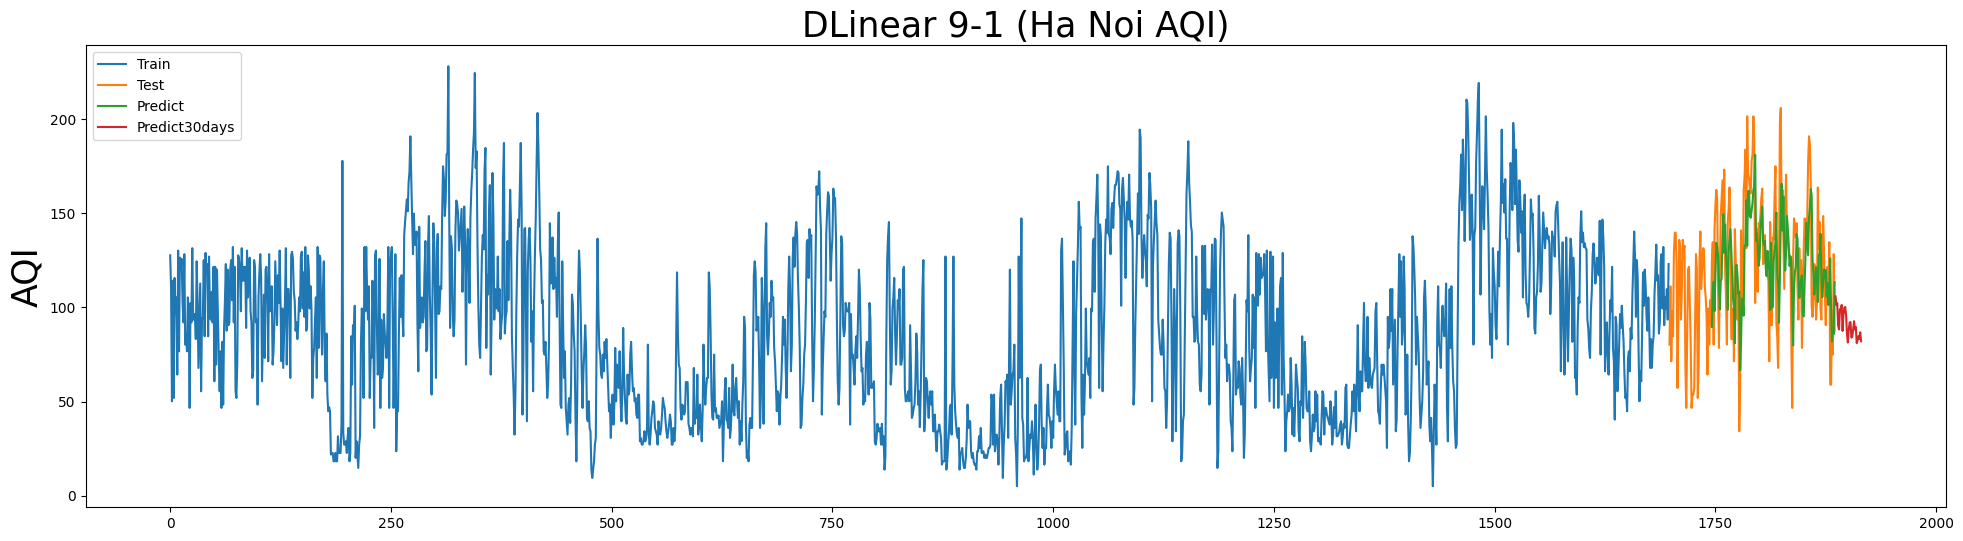

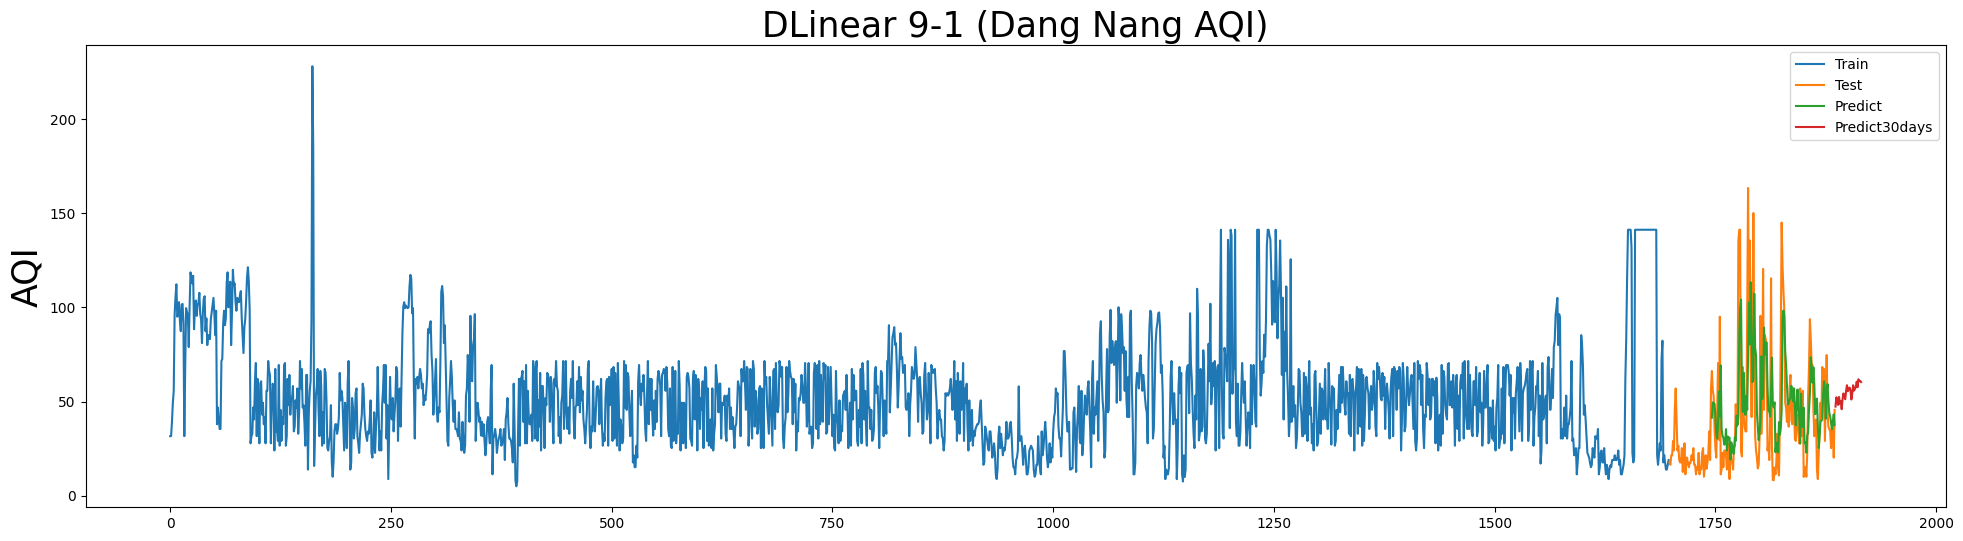

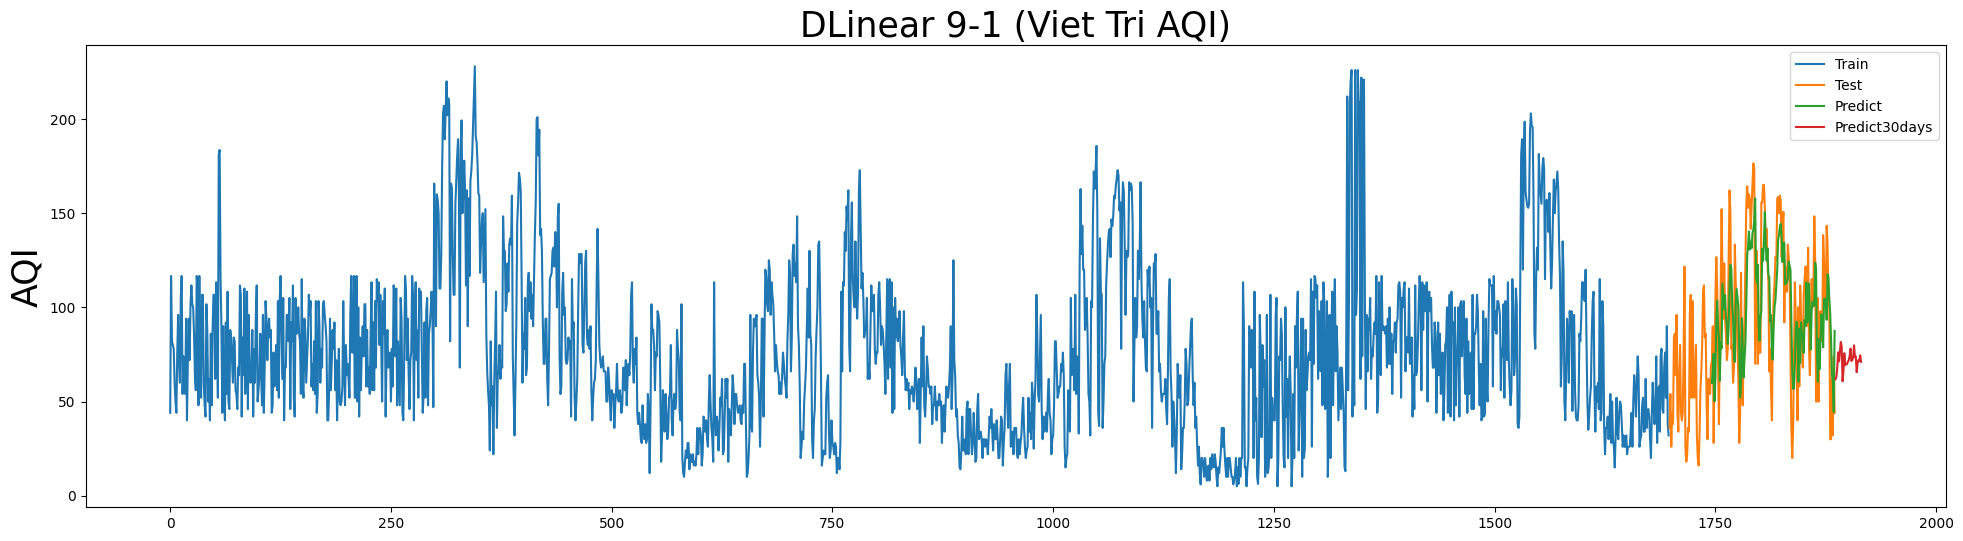

In [26]:
# Visualize the predictions
import matplotlib.pyplot as plt

## HaNoi
train_data_origin = scaler.inverse_transform(train_data_HaNoi)
test_data_origin = scaler.inverse_transform(test_data_HaNoi)
test_pred_origin = test_pred_HaNoi
pred_30_origin = predictions_HaNoi

test_data_index = pd.RangeIndex(start=len(train_data_origin), stop=len(train_data_origin)+len(test_data_origin), step=1)
test_pred_index = pd.RangeIndex(start=len(train_data_origin)+configs.seq_len+configs.pred_len-1, stop=len(train_data_origin)+len(test_data_origin), step=1)
pred_30_index = pd.RangeIndex(start=len(train_data_origin)+len(test_data_origin), stop=len(train_data_origin)+len(test_data_origin)+prediction_days, step=1)

plt.figure(figsize=(24, 6))
plt.title('DLinear 9-1 (Ha Noi AQI)', fontsize=25)
plt.ylabel('AQI', fontsize=25)

plt.plot(train_data_origin)
plt.plot(test_data_index, test_data_origin)
plt.plot(test_pred_index, test_pred_origin)
plt.plot(pred_30_index, pred_30_origin)
plt.legend(['Train','Test','Predict','Predict30days'])

## DaNang
train_data_origin = scaler.inverse_transform(train_data_DaNang)
test_data_origin = scaler.inverse_transform(test_data_DaNang)
test_pred_origin = test_pred_DaNang
pred_30_origin = predictions_DaNang

test_data_index = pd.RangeIndex(start=len(train_data_origin), stop=len(train_data_origin)+len(test_data_origin), step=1)
test_pred_index = pd.RangeIndex(start=len(train_data_origin)+configs.seq_len+configs.pred_len-1, stop=len(train_data_origin)+len(test_data_origin), step=1)
pred_30_index = pd.RangeIndex(start=len(train_data_origin)+len(test_data_origin), stop=len(train_data_origin)+len(test_data_origin)+prediction_days, step=1)

plt.figure(figsize=(24, 6))
plt.title('DLinear 9-1 (Dang Nang AQI)', fontsize=25)
plt.ylabel('AQI', fontsize=25)

plt.plot(train_data_origin)
plt.plot(test_data_index, test_data_origin)
plt.plot(test_pred_index, test_pred_origin)
plt.plot(pred_30_index, pred_30_origin)
plt.legend(['Train','Test','Predict','Predict30days'])

## VietTri
train_data_origin = scaler.inverse_transform(train_data_VietTri)
test_data_origin = scaler.inverse_transform(test_data_VietTri)
test_pred_origin = test_pred_VietTri
pred_30_origin = predictions_VietTri

test_data_index = pd.RangeIndex(start=len(train_data_origin), stop=len(train_data_origin)+len(test_data_origin), step=1)
test_pred_index = pd.RangeIndex(start=len(train_data_origin)+configs.seq_len+configs.pred_len-1, stop=len(train_data_origin)+len(test_data_origin), step=1)
pred_30_index = pd.RangeIndex(start=len(train_data_origin)+len(test_data_origin), stop=len(train_data_origin)+len(test_data_origin)+prediction_days, step=1)

plt.figure(figsize=(24, 6))
plt.title('DLinear 9-1 (Viet Tri AQI)', fontsize=25)
plt.ylabel('AQI', fontsize=25)

plt.plot(train_data_origin)
plt.plot(test_data_index, test_data_origin)
plt.plot(test_pred_index, test_pred_origin)
plt.plot(pred_30_index, pred_30_origin)
plt.legend(['Train','Test','Predict','Predict30days'])



In [27]:
#tính RMSE,MAPE,MAE cho tâp test
from sklearn.metrics import mean_squared_error
from math import sqrt

## HaNoi
print('HaNoi')
test_data_origin = scaler.inverse_transform(test_data_HaNoi)
test_pred_origin = test_pred_HaNoi

test_data_origin_1 = test_data_origin[configs.seq_len+configs.pred_len-1:]
rmse = sqrt(mean_squared_error(test_pred_origin, test_data_origin_1))
mape = np.mean(np.abs((test_pred_origin - test_data_origin_1) /test_data_origin_1)) * 100
mae = np.mean(np.abs(test_pred_origin - test_data_origin_1))
print('Test RMSE: %.3f' % rmse)
print('Test MAPE: %.3f' % mape)
print('Test MAE: %.3f' % mae)

print('DaNang')
test_data_origin = scaler.inverse_transform(test_data_DaNang)
test_pred_origin = test_pred_DaNang

test_data_origin_1 = test_data_origin[configs.seq_len+configs.pred_len-1:]
rmse = sqrt(mean_squared_error(test_pred_origin, test_data_origin_1))
mape = np.mean(np.abs((test_pred_origin - test_data_origin_1) /test_data_origin_1)) * 100
mae = np.mean(np.abs(test_pred_origin - test_data_origin_1))
print('Test RMSE: %.3f' % rmse)
print('Test MAPE: %.3f' % mape)
print('Test MAE: %.3f' % mae)

## VietTri
print('VietTri')
test_data_origin = scaler.inverse_transform(test_data_VietTri)
test_pred_origin = test_pred_VietTri

test_data_origin_1 = test_data_origin[configs.seq_len+configs.pred_len-1:]
rmse = sqrt(mean_squared_error(test_pred_origin, test_data_origin_1))
mape = np.mean(np.abs((test_pred_origin - test_data_origin_1) /test_data_origin_1)) * 100
mae = np.mean(np.abs(test_pred_origin - test_data_origin_1))
print('Test RMSE: %.3f' % rmse)
print('Test MAPE: %.3f' % mape)
print('Test MAE: %.3f' % mae)


HaNoi
Test RMSE: 32.141
Test MAPE: 23.689
Test MAE: 26.331
DaNang
Test RMSE: 29.563
Test MAPE: 69.766
Test MAE: 21.801
VietTri
Test RMSE: 31.197
Test MAPE: 34.820
Test MAE: 25.625
